# Predicting Heart Disease
> **Kaggle Playground Series S6E2**

### Executive Summary

**Objective**
- Build a reliable binary classifier for heart disease (`Absence` vs `Presence`) using robust statistical EDA.

**Dataset Snapshot**
- Train: `630,000 x 15` | Test: `270,000 x 14`
- Class balance (train): `Absence 55.17%`, `Presence 44.83%`
- Data quality: no missing values, no duplicate feature rows

**Drift & Stability**
- Numeric drift is low by both distribution-shape and mean-shift diagnostics (`KS` + `SMD`).
- Practical implication: low train-test shift risk under current feature space.

**Most Informative Features**
- Numerical (PointBiserial~Pearson):
  - `Max HR (r=-0.441)`
  - `ST depression (r=0.431)`
  - `Age (r=0.212)`
- Categorical (Cramer's V):
  - `Thallium (0.606)`
  - `Chest pain type (0.525)`
  - `Number of vessels fluro (0.463)`
  - `Exercise angina (0.442)`

**Interaction Insight**
- Pairwise NUM/CAT interaction heatmaps show stronger risk separation than single-feature views, supporting interaction-aware feature engineering.

**Final Modeling Direction**
- Validation: `StratifiedKFold (5 folds)`
- Main metric: `ROC-AUC` (secondary: `PR-AUC`, thresholded `F1`)
- Model priority: `CatBoost` first, then `LightGBM` / `XGBoost`
- Feature policy: keep medical code features categorical; add interactions only with stable CV lift
- Deployment guardrail: monitor incoming-data drift with periodic `KS/SMD` checks

**Relevant Sections**
- Drift: `2.5`, `2.6`
- Single-feature signals: `3.1`, `3.2`
- Interaction signals: `4.3`, `4.4`
- Final playbook: `5`


### Dataset Background Knowledge (Quick Guide)
Before running the EDA, here is background summary of what each feature means.

- `Age`: Patient age in years. Older age is generally associated with higher heart disease risk.
- `Sex`: Biological sex code (commonly 0/1). Heart disease prevalence and pattern often differ by sex.
- `Chest pain type`: Type of chest pain symptom (coded categories). Some chest-pain patterns are strongly linked to coronary disease.
- `BP`: Resting blood pressure (mmHg). Persistently high blood pressure is a known cardiovascular risk factor.
- `Cholesterol`: Serum cholesterol level (mg/dL). High cholesterol is a classic risk factor for atherosclerosis.
- `FBS over 120`: Fasting blood sugar indicator (>120 mg/dL: yes/no). Elevated glucose can reflect metabolic risk tied to cardiovascular disease.
- `EKG results`: Resting ECG result category. Certain ECG abnormalities can indicate cardiac stress or damage.
- `Max HR`: Maximum heart rate achieved during test/exercise. Abnormally low exercise capacity can be associated with heart disease.
- `Exercise angina`: Whether exercise-induced chest pain occurred (yes/no). This is commonly associated with obstructive coronary disease.
- `ST depression`: ST-segment depression during exercise vs rest (numeric). Larger ST depression is a classic ischemia-related signal.
- `Slope of ST`: Slope type of peak exercise ST segment (coded). Clinically used with ST depression to assess ischemic patterns.
- `Number of vessels fluro`: Number of major vessels seen by fluoroscopy (coded count). Higher values often indicate more severe vessel involvement.
- `Thallium`: Thallium stress test result category (coded). Abnormal thallium findings are strongly associated with coronary disease.
- `Heart Disease` (target): Label indicating absence/presence of heart disease.

Notes:
- Several variables are numeric-looking but are actually clinical category codes (`Chest pain type`, `EKG results`, `Slope of ST`, `Thallium`).
- Associations above are broad clinical background, not causal proof from this dataset alone.


## 0. Import Libraries and Datasets


### 0.1. Import Libraries and Setup
Set plotting styles, statistics tools, and display options used across the analysis.


In [1]:
# =================================================================================
# LIBRARIES & BASIC SETUP
# =================================================================================
import warnings
warnings.filterwarnings('ignore')  # Ignore warnings to keep the notebook clean

# Data Manipulation
import pandas as pd
import numpy as np

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.colors as mcolors
import matplotlib.patches as mpatches
import textwrap
from pprint import pformat

# Statistics
from scipy import stats
from scipy.stats import (
    ks_2samp,       # Distribution comparison (Train vs Test)
    pearsonr,       # Linear correlation
    spearmanr,      # Monotonic correlation (Non-linear)
    f_oneway,       # ANOVA (Categorical vs Numerical)
    kruskal         # Kruskal-Wallis (Non-parametric ANOVA)
)

# Pandas Display Options
pd.set_option('display.max_columns', None)
pd.set_option('display.precision', 3)

# =================================================================================
# PROFESSIONAL COLOR PALETTE (Academic/Score Theme)
# =================================================================================
# Theme: Gradient from Low Score (Warning) to High Score (Success)
COLORS = {
    'low_score': '#EF4444',    # Red: Low performance
    'mid_score': '#F59E0B',    # Amber: Average performance
    'high_score': '#10B981',   # Emerald Green: High performance
    'primary': '#2563EB',      # Royal Blue: General data
    'secondary': '#6B7280',  # Gray (Text/Lines) - [FIXED HERE]
    'accent': '#F59E0B',       # Amber: Highlight/Attention (Added back)
    'dark': '#1F2937',         # Dark Gray: Text
    'light': '#F3F4F6',        # Light Gray: Backgrounds
    'grid': '#E5E7EB'          # Light Gray: Grid lines
}

# Continuous Colormap for Correlation Matrices
CMAP_CORE = sns.diverging_palette(10, 130, as_cmap=True)


# =================================================================================
# UNIFIED NOTEBOOK FORMATTING HELPERS (Aligned with Pred.ipynb)
# =================================================================================
FIG_WIDTH = 14
FIG_ROW_HEIGHT = 4.2
FIG_SMALL = (7.0, 4.2)
FIG_MEDIUM = (10.0, 5.0)


def figsize_by_rows(n_rows, width=FIG_WIDTH, row_height=FIG_ROW_HEIGHT):
    return (width, max(row_height, row_height * n_rows))


def print_section(title, width=84):
    print('\n' + '=' * width)
    print(title)
    print('=' * width)


def _format_display_value(value, items_per_line=5, wrap_width=96):
    if isinstance(value, (list, tuple, set, np.ndarray, pd.Index)):
        seq = list(value)
        if len(seq) == 0:
            text = '-'
        else:
            lines = [', '.join(map(str, seq[i:i + items_per_line])) for i in range(0, len(seq), items_per_line)]
            text = '\n'.join(lines)
    elif isinstance(value, dict):
        text = pformat(value, width=wrap_width, sort_dicts=False, compact=False)
    else:
        text = str(value)

    wrapped = []
    for line in str(text).splitlines() or [str(text)]:
        if len(line) <= wrap_width:
            wrapped.append(line)
        else:
            wrapped.extend(
                textwrap.wrap(
                    line,
                    width=wrap_width,
                    break_long_words=False,
                    break_on_hyphens=False,
                )
            )
    return '\n'.join(wrapped)


def display_kv(title, pairs, items_per_line=5, wrap_width=96):
    print_section(title)
    rows = [(k, _format_display_value(v, items_per_line=items_per_line, wrap_width=wrap_width)) for k, v in pairs]
    df = pd.DataFrame(rows, columns=['Item', 'Value'])
    styler = (
        df.style
        .set_properties(subset=['Item', 'Value'], **{'text-align': 'left'})
        .set_properties(subset=['Value'], **{'white-space': 'pre-wrap'})
    )
    display(styler)


def display_notes(title, lines):
    # Render free-form text as a unified key-value output block.
    if isinstance(lines, str):
        message = lines
    else:
        message = '\n'.join([str(x) for x in lines])
    display_kv(title, [('Notes', message)], wrap_width=110)




### 0.2. Load Data
Load `train.csv` and `test.csv`. If available, load the original reference dataset for distribution comparison.


In [2]:
# =================================================================================
# Load Datasets
# =================================================================================

train = pd.read_csv('./train.csv')
test = pd.read_csv('./test.csv')

# If original files are available, load them for comparison
try:
    original = pd.read_csv('./Heart_Disease_Prediction.csv')
except FileNotFoundError:
    original = None

try:
    originalMod = pd.read_csv('./Heart_Disease_PredictionMod.csv')
except FileNotFoundError:
    originalMod = None

load_status = [
    ('train.csv', 'Loaded'),
    ('test.csv', 'Loaded'),
    ('Heart_Disease_Prediction.csv', 'Loaded' if original is not None else 'Not found'),
    ('Heart_Disease_PredictionMod.csv', 'Loaded' if originalMod is not None else 'Not found'),
]
display_kv('Dataset Load Status', load_status)

shape_rows = [
    ('Train shape', train.shape),
    ('Test shape', test.shape),
]
if original is not None:
    shape_rows.append(('Original shape', original.shape))
if originalMod is not None:
    shape_rows.append(('OriginalMod shape', originalMod.shape))
display_kv('Dataset Shapes', shape_rows)

print_section('Train Data - First 5 Rows')
display(train.head())

print_section('Test Data - First 5 Rows')
display(test.head())

if original is not None:
    print_section('Original Data - First 5 Rows')
    display(original.head())

print_section('Train Data Info')
train.info()

if original is not None:
    print_section('Original Data Info')
    original.info()



Dataset Load Status


,Item,Value
0,train.csv,Loaded
1,test.csv,Loaded
2,Heart_Disease_Prediction.csv,Loaded
3,Heart_Disease_PredictionMod.csv,Loaded



Dataset Shapes


,Item,Value
0,Train shape,"630000, 15"
1,Test shape,"270000, 14"
2,Original shape,"270, 14"
3,OriginalMod shape,"278, 14"



Train Data - First 5 Rows


,id,Age,Sex,Chest pain type,BP,Cholesterol,FBS over 120,EKG results,Max HR,Exercise angina,ST depression,Slope of ST,Number of vessels fluro,Thallium,Heart Disease
0,0,58,1,4,152,239,0,0,158,1,3.6,2,2,7,Presence
1,1,52,1,1,125,325,0,2,171,0,0.0,1,0,3,Absence
2,2,56,0,2,160,188,0,2,151,0,0.0,1,0,3,Absence
3,3,44,0,3,134,229,0,2,150,0,1.0,2,0,3,Absence
4,4,58,1,4,140,234,0,2,125,1,3.8,2,3,3,Presence



Test Data - First 5 Rows


,id,Age,Sex,Chest pain type,BP,Cholesterol,FBS over 120,EKG results,Max HR,Exercise angina,ST depression,Slope of ST,Number of vessels fluro,Thallium
0,630000,58,1,3,120,288,0,2,145,1,0.8,2,3,3
1,630001,55,0,2,120,209,0,0,172,0,0.0,1,0,3
2,630002,54,1,4,120,268,0,0,150,1,0.0,2,3,7
3,630003,44,0,3,112,177,0,0,168,0,0.9,1,0,3
4,630004,43,1,1,138,267,0,0,163,0,1.8,2,0,7



Original Data - First 5 Rows


,Age,Sex,Chest pain type,BP,Cholesterol,FBS over 120,EKG results,Max HR,Exercise angina,ST depression,Slope of ST,Number of vessels fluro,Thallium,Heart Disease
0,70,1,4,130,322,0,2,109,0,2.4,2,3,3,Presence
1,67,0,3,115,564,0,2,160,0,1.6,2,0,7,Absence
2,57,1,2,124,261,0,0,141,0,0.3,1,0,7,Presence
3,64,1,4,128,263,0,0,105,1,0.2,2,1,7,Absence
4,74,0,2,120,269,0,2,121,1,0.2,1,1,3,Absence



Train Data Info
<class 'pandas.DataFrame'>
RangeIndex: 630000 entries, 0 to 629999
Data columns (total 15 columns):
 #   Column                   Non-Null Count   Dtype  
---  ------                   --------------   -----  
 0   id                       630000 non-null  int64  
 1   Age                      630000 non-null  int64  
 2   Sex                      630000 non-null  int64  
 3   Chest pain type          630000 non-null  int64  
 4   BP                       630000 non-null  int64  
 5   Cholesterol              630000 non-null  int64  
 6   FBS over 120             630000 non-null  int64  
 7   EKG results              630000 non-null  int64  
 8   Max HR                   630000 non-null  int64  
 9   Exercise angina          630000 non-null  int64  
 10  ST depression            630000 non-null  float64
 11  Slope of ST              630000 non-null  int64  
 12  Number of vessels fluro  630000 non-null  int64  
 13  Thallium                 630000 non-null  int64  
 14

### 0.3. Feature Identification
Use domain-driven feature grouping into numerical and categorical sets for S6E2.


In [3]:
# =================================================================================
# FEATURE IDENTIFICATION & TYPE DEFINITION
# =================================================================================

# ---------------------------------------------------------------------------------
# Define Target and ID
# ---------------------------------------------------------------------------------
TARGET = 'Heart Disease'
TARGET_BIN = 'target_bin'
ID_COL = 'id'

# ---------------------------------------------------------------------------------
# 1. Feature Consistency Check
# ---------------------------------------------------------------------------------
ignore_cols = [ID_COL, TARGET, TARGET_BIN]

train_cols = [col for col in train.columns if col not in ignore_cols]
test_cols = [col for col in test.columns if col not in ignore_cols]

assert set(train_cols) == set(test_cols), "Error: Feature columns in Train and Test do not match!"

display_kv('Target and Feature Overview', [('Target Variable', TARGET), ('Task Type', 'Binary classification'), ('Predictor Feature Count', len(train_cols))])

# ---------------------------------------------------------------------------------
# 2. Domain-based feature typing for S6E2
# ---------------------------------------------------------------------------------
CATS = [
    'Sex', 'Chest pain type', 'FBS over 120', 'EKG results',
    'Exercise angina', 'Slope of ST', 'Number of vessels fluro', 'Thallium'
]

NUMS = [
    'Age', 'BP', 'Cholesterol', 'Max HR', 'ST depression'
]

# Keep only columns actually present in this run
CATS = [c for c in CATS if c in train_cols]
NUMS = [c for c in NUMS if c in train_cols]

display_kv('Feature Groups', [('Categorical Features', CATS), ('Categorical Count', len(CATS)), ('Numerical Features', NUMS), ('Numerical Count', len(NUMS))])



Target and Feature Overview


,Item,Value
0,Target Variable,Heart Disease
1,Task Type,Binary classification
2,Predictor Feature Count,13



Feature Groups


,Item,Value
0,Categorical Features,"Sex, Chest pain type, FBS over 120, EKG results, Exercise angina Slope of ST, Number of vessels fluro, Thallium"
1,Categorical Count,8
2,Numerical Features,"Age, BP, Cholesterol, Max HR, ST depression"
3,Numerical Count,5


### 0.4. Preprocessing for Binary Classification
Convert categorical code columns to `category` dtype and map target labels to `target_bin` (`Absence=0`, `Presence=1`).


In [4]:
# =================================================================================
# DATA PREPROCESSING FOR BINARY CLASSIFICATION
# =================================================================================

# 1. Cast known categorical code columns to categorical dtype for clean plotting
for df in [train, test] + ([original] if original is not None else []):
    for col in CATS:
        if col in df.columns:
            df[col] = df[col].astype('category')

# 2. Create binary target used by numeric statistics/plots
TARGET_MAP = {'Absence': 0, 'Presence': 1}
train[TARGET_BIN] = train[TARGET].map(TARGET_MAP)

if original is not None and TARGET in original.columns:
    original[TARGET_BIN] = original[TARGET].map(TARGET_MAP)

if train[TARGET_BIN].isna().any():
    unknown = train.loc[train[TARGET_BIN].isna(), TARGET].unique().tolist()
    display_kv('Target Mapping Warning', [('Issue', 'Unmapped target labels found in train'), ('Labels', unknown)])

display_kv('Preprocessing Summary', [('Categorical Casting', 'Applied to train/test/original (if available)'), ('Target Mapping', TARGET_MAP), ('target_bin meaning', '0=Absence, 1=Presence')])

# print(original[TARGET_BIN])




Preprocessing Summary


,Item,Value
0,Categorical Casting,Applied to train/test/original (if available)
1,Target Mapping,"{'Absence': 0, 'Presence': 1}"
2,target_bin meaning,"0=Absence, 1=Presence"


## 1. Data Quality Checks
Check missingness, duplicates, and feature cardinality before modeling decisions.


### 1.1. Missing Values Analysis
No missing values in train, test, or reference data.


In [5]:
# =================================================================================
# MISSING VALUES ANALYSIS
# =================================================================================
def check_missing_values(df, name):
    # 1. Aggregate Missing Values (Using Boolean Mask)
    missing = df.isnull().sum()
    missing = missing[missing > 0] # Filter only columns with missing values
    print_section(f'{name} - Missing Values Analysis', width=40)

    if missing.empty:
        display_kv(f'{name} - Missing Values', [('Status', 'No missing values found')])
        return None
    
    # 2. Construct DataFrame with Extended Information
    missing_df = pd.DataFrame({
        'Missing_Count': missing.values,
        'Missing_Percentage': (missing.values / len(df)) * 100,
        'Dtype': df[missing.index].dtypes # Critical for deciding imputation strategy
    }, index=missing.index)
    
    missing_df = missing_df.sort_values('Missing_Percentage', ascending=False)
    
    # 3. Visualization using Pandas Styler
    styled_df = missing_df.style.format({
        'Missing_Percentage': '{:.2f}%'
    }).bar(subset=['Missing_Percentage'], color=COLORS['low_score'], vmin=0, vmax=100)
    
    display(styled_df)
    
    return missing_df

train_missing = check_missing_values(train, "TRAIN")
test_missing = check_missing_values(test, "TEST")
if 'original' in globals():
    orig_missing = check_missing_values(original, "ORIGINAL")



TRAIN - Missing Values Analysis

TRAIN - Missing Values


,Item,Value
0,Status,No missing values found



TEST - Missing Values Analysis

TEST - Missing Values


,Item,Value
0,Status,No missing values found



ORIGINAL - Missing Values Analysis

ORIGINAL - Missing Values


,Item,Value
0,Status,No missing values found


> **Statistical Implication** -- No missingness means no imputation bias and fewer preprocessing branches. Model variance from data cleaning choices should remain low.


### 1.2. Duplicate Rows Check
No duplicate rows when checking by feature columns.


In [6]:
# =================================================================================
# DUPLICATE FEATURES CHECK (INCONSISTENCY DETECTION)
# =================================================================================
def check_duplicates(df, name, id_col=None, target_col=None, show_top=10):
    # --- header ---
    print_section(f'{name} - Duplicate Features Check', width=40)

    # --- resolve exclusions safely ---
    exclude_cols = []
    if id_col is not None:
        if id_col in df.columns:
            exclude_cols.append(id_col)
        else:
            display_kv('Duplicate Check Warning', [('Issue', f'id_col={repr(id_col)} not in columns; not excluded')])

    if target_col is not None:
        if target_col in df.columns:
            exclude_cols.append(target_col)
        else:
            display_kv('Duplicate Check Warning', [('Issue', f'target_col={repr(target_col)} not in columns; not excluded')])

    check_cols = [c for c in df.columns if c not in exclude_cols]

    display_kv(f'{name} - Duplicate Check Scope', [('Total Rows', f"{len(df):,}"), ('Feature Columns Used', len(check_cols))])
    

    if len(check_cols) == 0:
        display_kv(f'{name} - Duplicate Check', [('Status', 'Skipped'), ('Reason', 'No columns left after exclusions')])
        return None

    # --- duplicate detection ---
    num_dup_extra = int(df.duplicated(subset=check_cols, keep="first").sum())
    dup_any_mask = df.duplicated(subset=check_cols, keep=False)
    num_dup_rows_all = int(dup_any_mask.sum())

    display_kv(f'{name} - Duplicate Summary', [('Duplicate Features (Extra Rows)', f"{num_dup_extra:,} ({num_dup_extra/len(df)*100:.2f}%)"), ('Rows in Duplicate Groups', f"{num_dup_rows_all:,} ({num_dup_rows_all/len(df)*100:.2f}%)")])
    

    if num_dup_rows_all == 0:
        display_kv(f'{name} - Duplicate Check', [('Status', 'No duplicate feature sets found')])
        return {
            "duplicate_summary": {
                "num_dup_extra": num_dup_extra,
                "num_dup_rows_all": num_dup_rows_all,
                "num_inconsistent_groups": 0,
                "num_inconsistent_rows": 0,
            }
        }

    # show duplicates (optional)
    display_cols = check_cols + ([target_col] if (target_col in df.columns) else [])
    dup_examples = df.loc[dup_any_mask, display_cols].copy()

    try:
        dup_examples = dup_examples.sort_values(by=check_cols)
    except Exception:
        pass

    print_section(f'{name} - Duplicate Samples (Top {show_top})', width=60)
    display(dup_examples.head(show_top))

    # --- inconsistency detection (only if target exists) ---
    num_inconsistent_groups = 0
    num_inconsistent_rows = 0

    if target_col in df.columns:
        g = df.groupby(check_cols, dropna=False)[target_col].nunique()
        inconsistent_keys = g[g >= 2].index
        num_inconsistent_groups = int(len(inconsistent_keys))

        if num_inconsistent_groups > 0:
            key_df = pd.DataFrame(list(inconsistent_keys), columns=check_cols)
            inconsistent_rows = df.merge(key_df, on=check_cols, how="inner")
            num_inconsistent_rows = int(len(inconsistent_rows))

            print_section(f'{name} - Inconsistency Detection', width=60)
            display_kv(f'{name} - Inconsistency Summary', [('Inconsistent Feature Groups', f"{num_inconsistent_groups:,}"), ('Rows in Inconsistent Groups', f"{num_inconsistent_rows:,} ({num_inconsistent_rows/len(df)*100:.2f}%)")])
            

    return {
        "duplicate_summary": {
            "num_dup_extra": num_dup_extra,
            "num_dup_rows_all": num_dup_rows_all,
            "num_inconsistent_groups": num_inconsistent_groups,
            "num_inconsistent_rows": num_inconsistent_rows,
        }
    }

dup_train = check_duplicates(train, "TRAIN", id_col=ID_COL, target_col=TARGET)
dup_test  = check_duplicates(test,  "TEST",  id_col=ID_COL, target_col=TARGET) 
dup_orig  = check_duplicates(original, "ORIGINAL", id_col="id", target_col=TARGET) if "original" in globals() else None



TRAIN - Duplicate Features Check

TRAIN - Duplicate Check Scope


,Item,Value
0,Total Rows,"630,000"
1,Feature Columns Used,14



TRAIN - Duplicate Summary


,Item,Value
0,Duplicate Features (Extra Rows),0 (0.00%)
1,Rows in Duplicate Groups,0 (0.00%)



TRAIN - Duplicate Check


,Item,Value
0,Status,No duplicate feature sets found



TEST - Duplicate Features Check

Duplicate Check Warning


,Item,Value
0,Issue,target_col='Heart Disease' not in columns; not excluded



TEST - Duplicate Check Scope


,Item,Value
0,Total Rows,"270,000"
1,Feature Columns Used,13



TEST - Duplicate Summary


,Item,Value
0,Duplicate Features (Extra Rows),0 (0.00%)
1,Rows in Duplicate Groups,0 (0.00%)



TEST - Duplicate Check


,Item,Value
0,Status,No duplicate feature sets found



ORIGINAL - Duplicate Features Check

Duplicate Check Warning


,Item,Value
0,Issue,id_col='id' not in columns; not excluded



ORIGINAL - Duplicate Check Scope


,Item,Value
0,Total Rows,270
1,Feature Columns Used,14



ORIGINAL - Duplicate Summary


,Item,Value
0,Duplicate Features (Extra Rows),0 (0.00%)
1,Rows in Duplicate Groups,0 (0.00%)



ORIGINAL - Duplicate Check


,Item,Value
0,Status,No duplicate feature sets found


> **Statistical Implication** -- No duplicate feature rows suggests low data redundancy and lower leakage-like artifacts. Training signal is less likely to be inflated by repeated patterns.


### 1.3. Unique Values Count
Numeric columns show enough variation; categorical columns follow low-cardinality medical coding structure.


In [7]:
# =================================================================================
# UNIQUE VALUES ANALYSIS
# =================================================================================
def check_unique_values(train_df, test_df, features, original_df=None):
    print_section('Unique Values Analysis', width=40)
    
    # 1. Basic Calculation (Train & Test)
    # Using vectorized 'nunique()' is faster than looping
    train_nunique = train_df[features].nunique()
    test_nunique = test_df[features].nunique()
    
    # Construct data dictionary
    data_dict = {
        'Dtype': train_df[features].dtypes,
        'Train_Unique': train_nunique,
        'Test_Unique': test_nunique,
        'Cardinality_Ratio(%)': (train_nunique / len(train_df)) * 100
    }
    
    # Initialize columns for gradient styling
    gradient_cols = ['Train_Unique', 'Test_Unique']
    
    # 2. Original Data Processing (Optional)
    if original_df is not None:
        # Reindex ensures we handle missing columns in Original set gracefully
        orig_nunique = original_df.reindex(columns=features).nunique()
        
        data_dict['Original_Unique'] = orig_nunique
        gradient_cols.append('Original_Unique')
    
    # 3. DataFrame Construction
    unique_df = pd.DataFrame(data_dict)
    
    # Derived Metric: Difference between Test and Train cardinality
    # Positive value implies unseen categories in Test set (for categorical vars)
    unique_df['Diff_Train_Test'] = unique_df['Test_Unique'] - unique_df['Train_Unique']

    # Reorder columns for clearer comparison
    col_order = ['Dtype', 'Train_Unique', 'Test_Unique']
    if 'Original_Unique' in unique_df.columns:
        col_order.append('Original_Unique')
    col_order += ['Cardinality_Ratio(%)', 'Diff_Train_Test']
    unique_df = unique_df[col_order]

    # Sort by cardinality (low to high)
    unique_df = unique_df.sort_values('Train_Unique', ascending=True)
    
    # 4. Visualization
    styled_df = unique_df.style\
        .format({'Cardinality_Ratio(%)': '{:.2f}%'})\
        .background_gradient(subset=gradient_cols, cmap='viridis')\
        .bar(subset=['Cardinality_Ratio(%)'], color=COLORS['accent'], vmin=0, vmax=100)
    
    # Warning for Constant Features
    constant_cols = unique_df[unique_df['Train_Unique'] == 1].index.tolist()
    if constant_cols:
        display_kv('Constant Feature Warning', [('Constant Feature Count', len(constant_cols)), ('Columns', constant_cols), ('Recommendation', 'Drop these columns because they add no information')])
        
    display(styled_df)
    return unique_df

# We use 'train_cols' to exclude ID and Target from this check
_ = check_unique_values(train, test, train_cols, original_df=original if 'original' in globals() else None)



Unique Values Analysis


,Dtype,Train_Unique,Test_Unique,Original_Unique,Cardinality_Ratio(%),Diff_Train_Test
Sex,category,2,2,2,0.00%,0
FBS over 120,category,2,2,2,0.00%,0
Exercise angina,category,2,2,2,0.00%,0
EKG results,category,3,3,3,0.00%,0
Slope of ST,category,3,3,3,0.00%,0
Thallium,category,3,3,3,0.00%,0
Chest pain type,category,4,4,4,0.00%,0
Number of vessels fluro,category,4,4,4,0.00%,0
Age,int64,42,43,41,0.01%,1
BP,int64,66,64,47,0.01%,-2


> **Statistical Implication** -- Feature cardinality structure supports a mixed strategy: numeric modeling + categorical handling. Low-cardinality medical code variables are suitable for category-aware models.


## 2. Drift & Distribution Analysis
This section combines target-distribution checks and train-test drift diagnostics.


### 2.1. Target Variable Distribution Shift
Compare class balance between train and original reference data first, then continue with numeric/categorical drift diagnostics.



Target Variable Analysis: Heart Disease


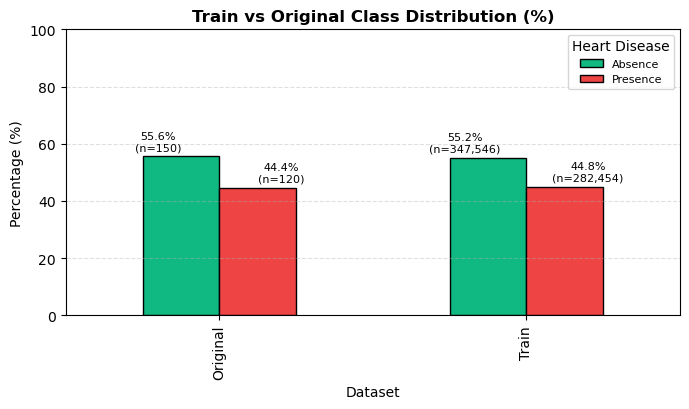


Class Balance Summary


,Count_Absence,Count_Presence,Pct_Absence(%),Pct_Presence(%)
Dataset,,,,
Original,150,120,55.556,44.444
Train,347546,282454,55.166,44.834


In [8]:

# =================================================================================
# TARGET VARIABLE ANALYSIS (BINARY CLASSIFICATION)
# =================================================================================
def analyze_target_variable_binary(train_df, target_col, target_bin_col, original_df=None, colors=None):
    print_section(f"Target Variable Analysis: {target_col}", width=40)

    if colors is None:
        colors = {'high_score': '#10B981', 'low_score': '#EF4444', 'primary': '#2563EB'}

    # Robustly fetch a single target series even if duplicate column labels exist.
    def _target_series(df, col):
        ser = df.loc[:, col]
        if isinstance(ser, pd.DataFrame):
            ser = ser.iloc[:, 0]
        return ser

    if original_df is not None and target_col in original_df.columns:
        train_target = _target_series(train_df, target_col)
        original_target = _target_series(original_df, target_col)

        plot_df = pd.concat([
            pd.DataFrame({target_col: train_target, 'Dataset': 'Train'}),
            pd.DataFrame({target_col: original_target, 'Dataset': 'Original'})
        ], ignore_index=True)

        count_tbl = pd.crosstab(plot_df['Dataset'], plot_df[target_col])
        # Guard against duplicate labels before reindex.
        count_tbl = count_tbl.T.groupby(level=0).sum().T
        classes = ['Absence', 'Presence']
        count_tbl = count_tbl.reindex(columns=classes, fill_value=0)
        pct_tbl = count_tbl.div(count_tbl.sum(axis=1).replace(0, np.nan), axis=0).mul(100).fillna(0)

        fig, ax = plt.subplots(1, 1, figsize=FIG_SMALL)
        pct_tbl.plot(
            kind='bar', ax=ax,
            color=[colors['high_score'], colors['low_score']],
            edgecolor='black', linewidth=1
        )

        ax.set_title('Train vs Original Class Distribution (%)', fontweight='bold')
        ax.set_xlabel('Dataset')
        ax.set_ylabel('Percentage (%)')
        ax.set_ylim(0, 100)
        ax.legend(title=target_col, fontsize=8)
        ax.grid(axis='y', linestyle='--', alpha=0.4)

        # Add both percentage and absolute counts
        for dataset_idx, dataset_name in enumerate(pct_tbl.index):
            for class_idx, cls in enumerate(classes):
                pct = pct_tbl.loc[dataset_name, cls]
                cnt = int(count_tbl.loc[dataset_name, cls])
                x = dataset_idx + (-0.2 if class_idx == 0 else 0.2)
                ax.text(x, pct + 1.5, f"{pct:.1f}%\n(n={cnt:,})", ha='center', va='bottom', fontsize=8)

        plt.tight_layout()
        plt.show()

        print_section('Class Balance Summary')
        summary = count_tbl.copy()
        summary.columns = [f"Count_{c}" for c in summary.columns]
        for c in classes:
            summary[f"Pct_{c}(%)"] = pct_tbl[c].round(3)
        display(summary)

    else:
        # Fallback when original data is not available
        train_target = train_df.loc[:, target_col]
        if isinstance(train_target, pd.DataFrame):
            train_target = train_target.iloc[:, 0]
        train_counts = train_target.value_counts().reindex(['Absence', 'Presence']).fillna(0)
        train_ratio = train_target.value_counts(normalize=True).mul(100).reindex(['Absence', 'Presence']).fillna(0)

        fig, ax = plt.subplots(1, 1, figsize=FIG_SMALL)
        bars = ax.bar(['Absence', 'Presence'], train_ratio.values, color=[colors['high_score'], colors['low_score']],
                      edgecolor='black', linewidth=1)
        ax.set_title('Train Class Distribution (%)', fontweight='bold')
        ax.set_ylabel('Percentage (%)')
        ax.set_ylim(0, 100)
        ax.grid(axis='y', linestyle='--', alpha=0.4)
        for i, b in enumerate(bars):
            ax.text(b.get_x() + b.get_width()/2, b.get_height() + 1.5,
                    f"{train_ratio.iloc[i]:.1f}%\n(n={int(train_counts.iloc[i]):,})",
                    ha='center', va='bottom', fontsize=8)
        plt.tight_layout()
        plt.show()

analyze_target_variable_binary(
    train, TARGET, TARGET_BIN,
    original_df=original if original is not None else None,
    colors=COLORS
)


> **Statistical Implication** -- Train and original class proportions are close, so prior-shift risk is limited. Class-aware validation is still required, but no severe rebalance intervention is implied.


### 2.2. NUM - Statistical Summary



Dataset Comparison: Train vs Test vs Original

Comparison Step 1


,Item,Value
0,Notes,Statistical Summary (Mean/Std/Skew/Kurtosis)


,Train_mean,Test_mean,Orig_mean,Train_std,Test_std,Orig_std,Train_50%,Test_50%,Orig_50%,Train_skew,Test_skew,Orig_skew,Train_kurt,Test_kurt,Orig_kurt
Age,54.14,54.16,54.43,8.26,8.26,9.11,54.00,54.00,55.00,-0.16,-0.17,-0.16,-0.57,-0.58,-0.54
BP,130.50,130.56,131.34,14.98,15.01,17.86,130.00,130.00,130.00,0.63,0.62,0.72,0.93,0.93,0.92
Cholesterol,245.01,245.05,249.66,33.68,33.70,51.69,243.00,243.00,245.00,0.27,0.27,1.18,0.07,0.01,4.90
Max HR,152.82,152.78,149.68,19.11,19.15,23.17,157.00,157.00,153.50,-0.75,-0.75,-0.53,0.20,0.20,-0.10
ST depression,0.72,0.72,1.05,0.95,0.95,1.15,0.10,0.10,0.80,1.33,1.32,1.26,1.37,1.33,1.76



Comparison Step 2


,Item,Value
0,Notes,Feature Distribution Plots (Visual Check for Covariate Shift) Blue: Train | Amber: Test | Gray(dashed): Original


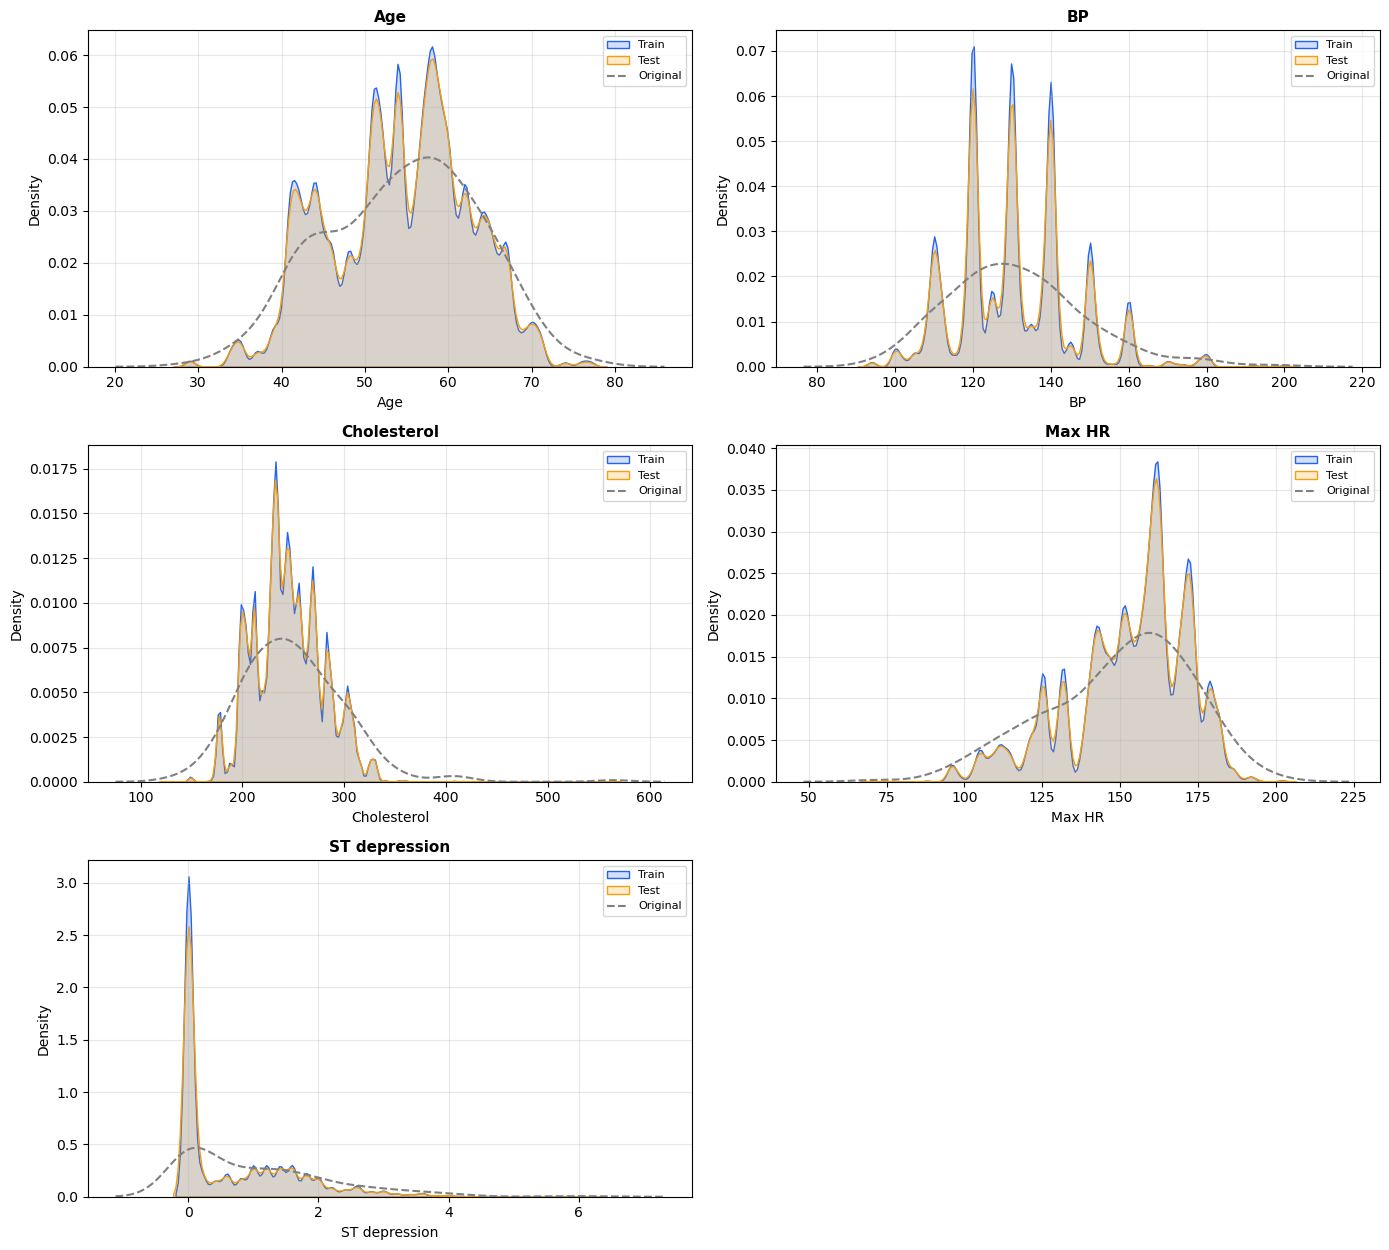

In [9]:
# =================================================================================
# DATASET COMPARISON: STATISTICS & DISTRIBUTIONS (INTEGRATED)
# =================================================================================
def analyze_dataset_distributions(train_df, test_df, original_df, features, target_col):
    print_section('Dataset Comparison: Train vs Test vs Original', width=40)

    display_notes('Comparison Step 1', 'Statistical Summary (Mean/Std/Skew/Kurtosis)')

    stats_list = []
    datasets = [('Train', train_df), ('Test', test_df)]
    if original_df is not None:
        datasets.append(('Orig', original_df))

    for name, df in datasets:
        current_feats = [f for f in features if f in df.columns]
        s = df[current_feats].describe().T[['mean', 'std', '50%']]
        s['skew'] = df[current_feats].skew()
        s['kurt'] = df[current_feats].kurt()
        s = s.add_prefix(f'{name}_')
        stats_list.append(s)

    combined_stats = pd.concat(stats_list, axis=1)

    metrics = ['mean', 'std', '50%', 'skew', 'kurt']
    sorted_cols = []
    for m in metrics:
        for name, _ in datasets:
            col_name = f'{name}_{m}'
            if col_name in combined_stats.columns:
                sorted_cols.append(col_name)

    display_df = combined_stats[sorted_cols]
    styled = display_df.style.format('{:.2f}')        .background_gradient(subset=[c for c in display_df.columns if 'mean' in c], cmap='Pastel1')        .background_gradient(subset=[c for c in display_df.columns if 'std' in c], cmap='Pastel2')        .bar(subset=[c for c in display_df.columns if 'skew' in c], align='mid',
             color=[COLORS['low_score'], COLORS['high_score']])
    display(styled)

    display_notes('Comparison Step 2', ['Feature Distribution Plots (Visual Check for Covariate Shift)', 'Blue: Train | Amber: Test | Gray(dashed): Original'])

    n_cols = 2
    total_plots = len(features) + (1 if target_col in train_df.columns and np.issubdtype(train_df[target_col].dtype, np.number) else 0)
    n_rows = (total_plots + n_cols - 1) // n_cols

    fig, axes = plt.subplots(n_rows, n_cols, figsize=figsize_by_rows(n_rows))
    axes = np.array(axes).reshape(-1)

    for i, col in enumerate(features):
        ax = axes[i]
        sns.kdeplot(train_df[col], fill=True, color=COLORS['primary'], label='Train', ax=ax, alpha=0.2)

        if col in test_df.columns:
            sns.kdeplot(test_df[col], fill=True, color=COLORS['accent'], label='Test', ax=ax, alpha=0.2)
            stat, p_val = ks_2samp(train_df[col], test_df[col])
            if p_val < 0.05:
                ax.text(0.95, 0.90, "KS p<0.05 (Diff!)", transform=ax.transAxes,
                        ha='right', color=COLORS['low_score'], fontweight='bold', fontsize=9)

        if original_df is not None and col in original_df.columns:
            sns.kdeplot(original_df[col], color='gray', linestyle='--', label='Original', ax=ax, linewidth=1.5)

        ax.set_title(col, fontsize=11, fontweight='bold')
        ax.grid(alpha=0.3)
        ax.legend(loc='best', fontsize=8)

    for j in range(len(features), len(axes)):
        fig.delaxes(axes[j])

    plt.tight_layout()
    plt.show()

if 'NUMS' in globals() and NUMS:
    analyze_dataset_distributions(
        train, test,
        original if original is not None else None,
        NUMS, TARGET_BIN
    )


> **Statistical Implication** -- Central tendency and spread across datasets appear aligned for major numeric features. This supports stable train-test transfer for tree-based classifiers.


### 2.3. NUM - Distribution Density & Outliers



Numerical Outliers Analysis (Box Plot Comparison)

Outlier Interpretation


,Item,Value
0,Notes,Check if test values exceed train range (extrapolation risk). Points outside whiskers are potential outliers.


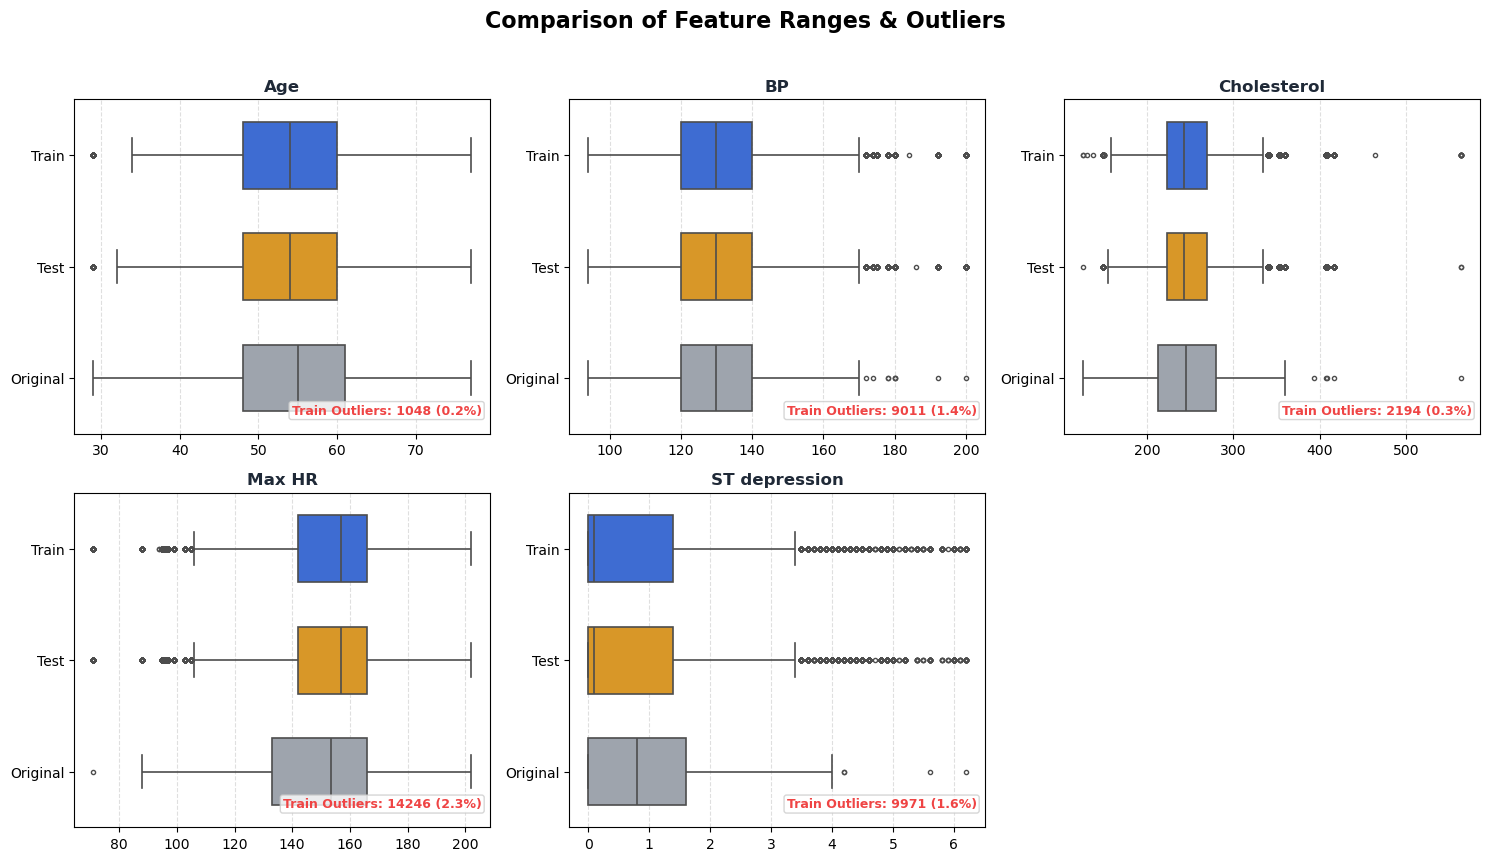

In [10]:
# =================================================================================
# NUMERICAL OUTLIERS ANALYSIS (TRAIN vs TEST vs ORIGINAL)
# =================================================================================
def analyze_numerical_outliers(train_df, test_df, original_df, features, cols_per_row=3):
    if not features:
        display_kv('Outlier Check', [('Status', 'Skipped'), ('Reason', 'No numerical features found')])
        return

    print_section('Numerical Outliers Analysis (Box Plot Comparison)')
    display_notes('Outlier Interpretation', ['Check if test values exceed train range (extrapolation risk).', 'Points outside whiskers are potential outliers.'])

    # 1. Prepare Data
    combined_data = []
    
    # Process Train
    temp = train_df[features].copy()
    temp['Dataset'] = 'Train'
    combined_data.append(temp)
    
    # Process Test
    temp = test_df[features].copy()
    temp['Dataset'] = 'Test'
    combined_data.append(temp)
    
    # Process Original (if exists)
    if original_df is not None:
        common_feats = [f for f in features if f in original_df.columns]
        if common_feats:
            temp = original_df[common_feats].copy()
            temp['Dataset'] = 'Original'
            combined_data.append(temp)
            
    df_all = pd.concat(combined_data, axis=0)
    
    # 2. Plotting
    n_rows = (len(features) + cols_per_row - 1) // cols_per_row
    fig, axes = plt.subplots(n_rows, cols_per_row, figsize=figsize_by_rows(n_rows, width=15))
    axes = axes.flatten()
    
    # Define Palette
    palette = {'Train': COLORS['primary'], 'Test': COLORS['accent'], 'Original': '#9CA3AF'}

    for i, col in enumerate(features):
        ax = axes[i]
        
        # Plot Boxplot (Horizontal)
        # This allows easy comparison of ranges (Min/Max/IQR) across datasets
        sns.boxplot(data=df_all, x=col, y='Dataset', palette=palette, ax=ax, 
                    width=0.6, linewidth=1.2, fliersize=3)
        
        # Statistics for Train set (Annotation)
        q1 = train_df[col].quantile(0.25)
        q3 = train_df[col].quantile(0.75)
        iqr = q3 - q1
        upper_bound = q3 + 1.5 * iqr
        
        # Calculate outliers count in Train
        n_outliers = ((train_df[col] < (q1 - 1.5 * iqr)) | (train_df[col] > upper_bound)).sum()
        pct_outliers = (n_outliers / len(train_df)) * 100
        
        # Add Title & Annotation
        ax.set_title(f'{col}', fontsize=12, fontweight='bold', color=COLORS['dark'])
        ax.set_xlabel('')
        ax.set_ylabel('')
        
        # Add text about Train outliers
        ax.text(0.98, 0.05, f'Train Outliers: {n_outliers} ({pct_outliers:.1f}%)', 
                transform=ax.transAxes, ha='right', va='bottom', 
                fontsize=9, fontweight='bold', color=COLORS['low_score'],
                bbox=dict(boxstyle='round,pad=0.2', facecolor='white', alpha=0.8, edgecolor='#ccc'))
        
        ax.grid(axis='x', linestyle='--', alpha=0.4)

    # Remove empty subplots
    for j in range(i + 1, len(axes)):
        fig.delaxes(axes[j])

    plt.suptitle('Comparison of Feature Ranges & Outliers', fontsize=16, fontweight='bold', y=1.02)
    plt.tight_layout()
    plt.show()

if 'NUMS' in globals() and NUMS:
    analyze_numerical_outliers(
        train, test, 
        original if 'original' in globals() else None, 
        NUMS, cols_per_row=3
    )


> **Statistical Implication** -- Outlier behavior is present but not catastrophically different between datasets. Robust models (boosted trees) should handle tails better than strict linear assumptions.


### 2.4. NUM - Skewness and Kurtosis


In [11]:
# =================================================================================
# DISTRIBUTION SHAPE & NORMALITY ANALYSIS (SKEWNESS / KURTOSIS)
# =================================================================================
from scipy.stats import jarque_bera

def analyze_distribution_shape(df, features, target_col=None):
    print_section('Distribution Shape & Normality Analysis', width=40)

    analysis_feats = features.copy()
    if target_col and target_col in df.columns:
        analysis_feats.append(target_col)
        display_kv('Distribution Shape Scope', [('Included Target Column', target_col)])

    skewness = df[analysis_feats].skew()
    kurtosis = df[analysis_feats].kurtosis()

    jb_stats = []
    p_values = []
    for col in analysis_feats:
        clean_data = df[col].dropna()
        stat, p = jarque_bera(clean_data)
        jb_stats.append(stat)
        p_values.append(p)

    dist_df = pd.DataFrame({
        'Skewness': skewness,
        'Kurtosis': kurtosis,
        'JB_Statistic': jb_stats,
        'P_Value': p_values
    }).sort_values('Skewness', key=abs, ascending=False)

    def interpret_skew(x):
        if abs(x) < 0.5: return 'Approx. Symmetric'
        if abs(x) < 1.0: return 'Moderately Skewed'
        return 'Highly Skewed'

    dist_df['Skew_Interpretation'] = dist_df['Skewness'].apply(interpret_skew)

    print_section('Distribution Shape Summary')

    styled = dist_df.style        .format({'Skewness': '{:.3f}', 'Kurtosis': '{:.3f}', 'JB_Statistic': '{:.2e}', 'P_Value': '{:.2e}'})        .background_gradient(subset=['Skewness'], cmap='coolwarm', vmin=-2, vmax=2)        .background_gradient(subset=['Kurtosis'], cmap='viridis', vmin=-2, vmax=10)
    display(styled)

    display_notes('Interpretation Guide', ['Skewness: |Skew| < 0.5 is stable, > 1.0 is highly skewed.', 'Kurtosis (Fisher): > 0 indicates heavier tails.'])

    return dist_df

if 'NUMS' in globals() and NUMS:
    dist_shape_df = analyze_distribution_shape(train, NUMS, target_col=TARGET_BIN)



Distribution Shape & Normality Analysis

Distribution Shape Scope


,Item,Value
0,Included Target Column,target_bin



Distribution Shape Summary


,Skewness,Kurtosis,JB_Statistic,P_Value,Skew_Interpretation
ST depression,1.328,1.375,2.35e+05,0.00e+00,Highly Skewed
Max HR,-0.755,0.204,6.09e+04,0.00e+00,Moderately Skewed
BP,0.629,0.933,6.44e+04,0.00e+00,Moderately Skewed
Cholesterol,0.273,0.068,7.96e+03,0.00e+00,Approx. Symmetric
target_bin,0.208,-1.957,1.05e+05,0.00e+00,Approx. Symmetric
Age,-0.164,-0.570,1.14e+04,0.00e+00,Approx. Symmetric



Interpretation Guide


,Item,Value
0,Notes,"Skewness: |Skew| < 0.5 is stable, > 1.0 is highly skewed. Kurtosis (Fisher): > 0 indicates heavier tails."


> **Statistical Implication** -- Skewed/heavy-tail variables indicate nonlinearity and threshold effects. This favors nonlinear models and interaction-aware feature learning.


### 2.5. NUM - KS Test: Distribution Similarity (Train vs Test)



Distribution Drift Analysis (KS Test)

KS Metric Guide


,Item,Value
0,Notes,Metric: KS Statistic (D) Interpretation: Low is good; high (>0.1) implies covariate shift.


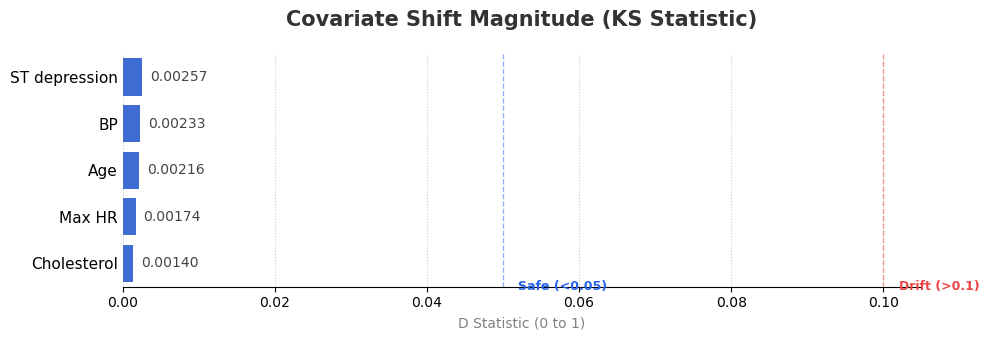


KS Drift Status


,Item,Value
0,Status,Train and test distributions are well-aligned


In [12]:
# =================================================================================
# =================================================================================
def analyze_ks_drift(train_df, test_df, nums):
    """
    Quantifies Distribution Drift between Train and Test using KS Statistic.
    - KS Statistic (D): 0.0 (Identical) ~ 1.0 (Completely Different).
    - Importance: Detects 'Covariate Shift'. If Train != Test, the model fails.
    """
    print_section('Distribution Drift Analysis (KS Test)', width=40)
    display_notes('KS Metric Guide', ['Metric: KS Statistic (D)', 'Interpretation: Low is good; high (>0.1) implies covariate shift.'])

    ks_results = []

    for col in nums:
        if col not in test_df.columns: continue
            
        try:
            stat, p_value = stats.ks_2samp(train_df[col], test_df[col])
        except Exception as e:
            display_kv('KS Drift Warning', [('Feature', col), ('Issue', str(e)), ('Action', 'Skipped this feature')])
            continue
        
        # 2. Determine Drift Magnitude (Heuristics)
        # < 0.05: Safe
        # < 0.10: Warning
        # > 0.10: Critical Drift
        if stat < 0.05:
            drift_status = "Negligible"
            color = COLORS['primary']
        elif stat < 0.1:
            drift_status = "Small"
            color = COLORS['mid_score']
        else:
            drift_status = "Large (Drift)"
            color = COLORS['low_score']
            
        ks_results.append({
            'Feature': col,
            'KS_Statistic': stat,
            'P_Value': p_value,
            'Status': drift_status,
            'Color': color
        })

    if not ks_results: return None

    ks_df = pd.DataFrame(ks_results).sort_values('KS_Statistic', ascending=False)
    
    # -------------------------------------------------------
    # Visualization
    # -------------------------------------------------------
    plt.figure(figsize=(10, len(ks_df) * 0.5 + 1))
    
    ax = sns.barplot(data=ks_df, x='KS_Statistic', y='Feature', 
                     palette=ks_df['Color'].tolist(), linewidth=0)
    
    sns.despine(left=True, bottom=False)
    ax.grid(axis='x', linestyle=':', alpha=0.4, color='gray')
    ax.tick_params(axis='y', length=0, labelsize=11)
    
    plt.title("Covariate Shift Magnitude (KS Statistic)", 
              fontsize=15, fontweight='bold', color='#333333', pad=20)
    plt.xlabel("D Statistic (0 to 1)", fontsize=10, color='gray')
    plt.ylabel("")
    
    # Threshold Lines
    plt.axvline(0.05, color=COLORS['primary'], linestyle='--', alpha=0.5, linewidth=1)
    plt.text(0.052, len(ks_df)-0.5, 'Safe (<0.05)', color=COLORS['primary'], fontsize=9, va='center', fontweight='bold')
    
    plt.axvline(0.1, color=COLORS['low_score'], linestyle='--', alpha=0.5, linewidth=1)
    plt.text(0.102, len(ks_df)-0.5, 'Drift (>0.1)', color=COLORS['low_score'], fontsize=9, va='center', fontweight='bold')

    for i, v in enumerate(ks_df['KS_Statistic']):
        ax.text(v + 0.001, i, f'{v:.5f}', va='center', 
                fontsize=10, fontweight='medium', color='#444444')

    plt.tight_layout()
    plt.show()

    if ks_df['KS_Statistic'].mean() == 0.0:
        display_notes('KS Drift Alert', ['All KS statistics are exactly 0.0.', "Please verify that train and test are not identical."])

    # Summary
    drifted_feats = ks_df[ks_df['KS_Statistic'] > 0.1]['Feature'].tolist()
    if drifted_feats:
        display_kv('KS Drift Alert', [('Critical Drift Features', drifted_feats)])
    else:
        display_kv('KS Drift Status', [('Status', 'Train and test distributions are well-aligned')])
        
    return ks_df.drop(columns=['Color'])

if 'NUMS' in globals() and NUMS:
    ks_drift_df = analyze_ks_drift(train, test, NUMS)


> **Statistical Implication** -- Low KS values indicate weak shape-level drift in numeric marginals. Generalization risk from pure marginal shift is likely low.


### 2.6. NUM - SMD (Standardized Mean Difference)


In [13]:
# =================================================================================
# DRIFT EFFECT-SIZE ANALYSIS (SMD)
# =================================================================================
def check_statistics_diff(train_df, test_df, nums):
    """
    Compares Train vs Test means using Standardized Mean Difference (SMD).
    - Metric: Cohen's d (Difference in units of pooled standard deviation).
    - Advantage: Robust to scale differences (unlike % diff).
    """
    # 1. Safety Check: Filter columns present in BOTH datasets
    # This prevents errors if 'Target' is in 'nums' but not in 'test_df'
    common_nums = [c for c in nums if c in train_df.columns and c in test_df.columns]
    
    if not common_nums:
        display_kv('SMD Drift Check', [('Status', 'Skipped'), ('Reason', 'No common numerical features found')])
        return

    # 2. Calculate Stats (Vectorized - Super Fast)
    train_stats = train_df[common_nums].agg(['mean', 'std']).T
    test_stats = test_df[common_nums].agg(['mean', 'std']).T
    
    # 3. Calculate SMD (Physics-style: Signal-to-Noise Ratio)
    # diff = Delta Mu
    # pooled_std = Average Width (Sigma)
    diff = (train_stats['mean'] - test_stats['mean']).abs()
    pooled_std = np.sqrt((train_stats['std']**2 + test_stats['std']**2) / 2)
    
    smd = diff / pooled_std
    
    # 4. Create Summary DataFrame
    summary = pd.DataFrame({
        'Train_Mean': train_stats['mean'],
        'Test_Mean': test_stats['mean'],
        'Delta_Mu': train_stats['mean'] - test_stats['mean'], # Raw Difference
        'SMD (Sigma)': smd  # Normalized Difference
    })
    
    # Sort by SMD (Magnitude of shift)
    summary = summary.sort_values('SMD (Sigma)', ascending=False)
    
    print_section('Drift Effect-Size Summary (Mean Shift)')
    display_notes('SMD Guide', ['Metric: SMD (Standardized Mean Difference, Cohen\'s d)', 'SMD < 0.1: Negligible', 'SMD > 0.1: Small shift (monitor)', 'SMD > 0.2: Noticeable shift'])
    
    # 5. Gradient Visualization
    # Highlight high SMD values with Red background
    display(summary.style.background_gradient(subset=['SMD (Sigma)'], cmap='Reds', vmin=0, vmax=0.25)
                     .format("{:.4f}"))

    # Check for meaningful shifts
    shifted = summary[summary['SMD (Sigma)'] > 0.1]
    if len(shifted) > 0:
        display_kv('SMD Drift Alert', [('Shifted Feature Count (>0.1)', len(shifted)), ('Features', shifted.index.tolist())])
    else:
        display_kv('SMD Drift Status', [('Status', 'Mean-level drift is negligible across train/test')])

check_statistics_diff(train, test, NUMS)



Drift Effect-Size Summary (Mean Shift)

SMD Guide


,Item,Value
0,Notes,"Metric: SMD (Standardized Mean Difference, Cohen's d) SMD < 0.1: Negligible SMD > 0.1: Small shift (monitor) SMD > 0.2: Noticeable shift"


,Train_Mean,Test_Mean,Delta_Mu,SMD (Sigma)
BP,130.4974,130.5551,-0.0577,0.0038
Age,54.1367,54.1599,-0.0232,0.0028
ST depression,0.7160,0.7181,-0.0021,0.0022
Max HR,152.8168,152.7838,0.0330,0.0017
Cholesterol,245.0118,245.0453,-0.0335,0.0010



SMD Drift Status


,Item,Value
0,Status,Mean-level drift is negligible across train/test


> **Statistical Implication** -- SMD quantifies mean-level shift; low values imply small practical drift. Combined with KS, drift evidence is consistent with stable deployment assumptions.


### 2.7. CAT - Distribution of Features



Categorical Features Comparison (Normalized by Dataset Size)

Chart Notes


,Item,Value
0,Notes,Y-axis shows percentage for fair dataset-size comparison. Bar widths are visually standardized for categories.


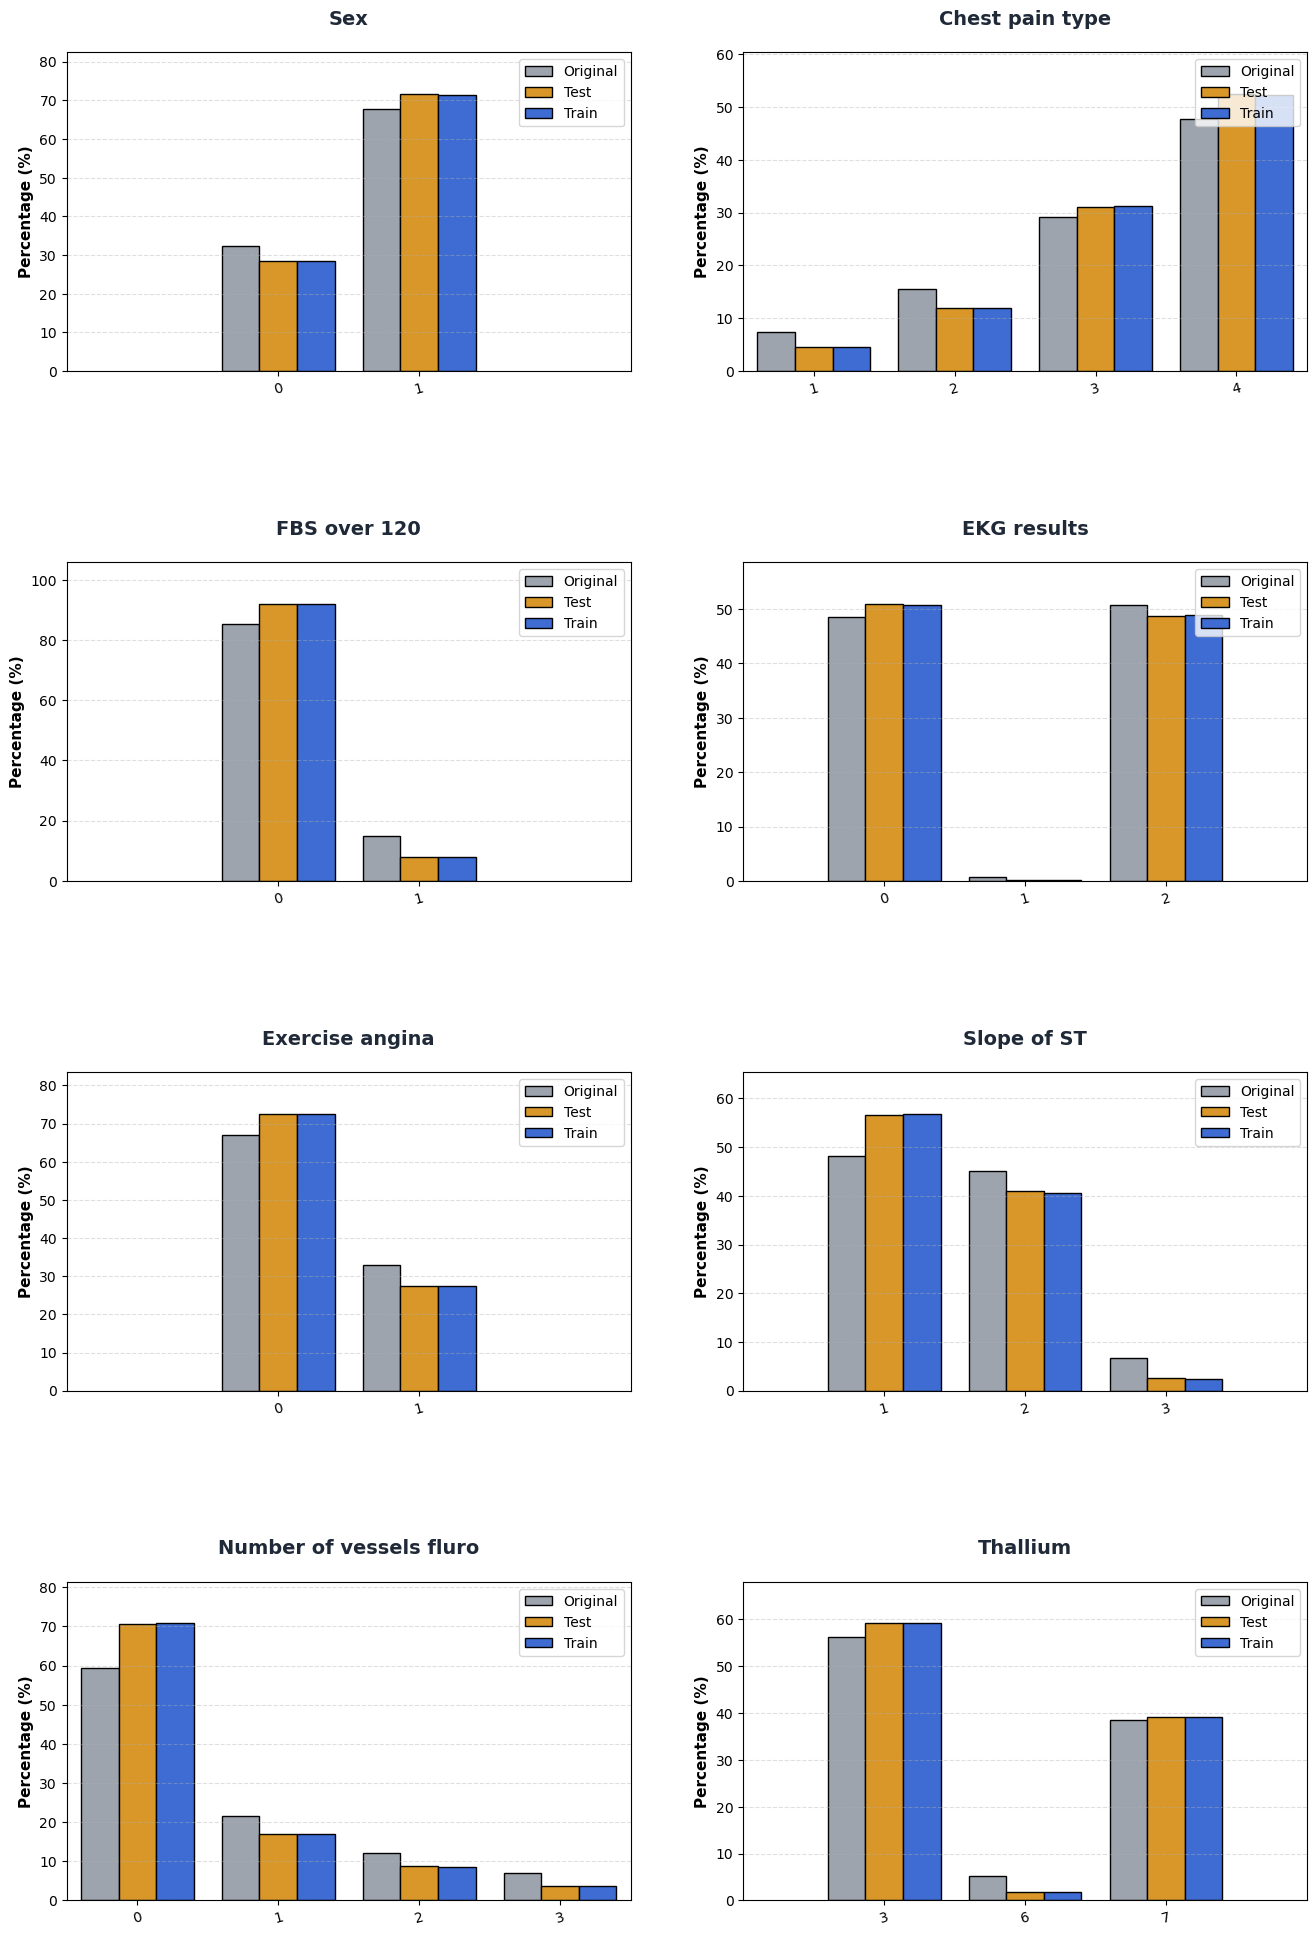

In [14]:
# =================================================================================
# CATEGORICAL FEATURES COMPARISON (TRAIN vs TEST vs ORIGINAL)
# =================================================================================
def compare_categorical_distributions(train_df, test_df, original_df, features, cols_per_row=2):
    if not features:
        display_kv('Categorical Distribution Comparison', [('Status', 'Skipped'), ('Reason', 'No categorical features found')])
        return

    print_section('Categorical Features Comparison (Normalized by Dataset Size)')
    display_notes('Chart Notes', ['Y-axis shows percentage for fair dataset-size comparison.', 'Bar widths are visually standardized for categories.'])

    # 1. Prepare Data: Combine and Calculate Percentages
    # We combine datasets into a long-format DataFrame for Seaborn
    combined_data = []
    
    # Process Train
    temp = train_df[features].copy()
    temp['Dataset'] = 'Train'
    combined_data.append(temp)
    
    # Process Test
    temp = test_df[features].copy()
    temp['Dataset'] = 'Test'
    combined_data.append(temp)
    
    # Process Original (if exists)
    if original_df is not None:
        common_feats = [f for f in features if f in original_df.columns]
        if common_feats:
            temp = original_df[common_feats].copy()
            temp['Dataset'] = 'Original'
            combined_data.append(temp)
            
    df_all = pd.concat(combined_data, axis=0)

    # Calculate Global Max Categories to standardize bar width
    # We find the feature with the MAXIMUM number of categories (e.g., 10)
    # and use this to set the x-axis limits for ALL plots.
    max_cats = 0
    for col in features:
        if train_df[col].dtype.name == 'category':
            n = len(train_df[col].cat.categories)
        else:
            n = train_df[col].nunique()
        if n > max_cats:
            max_cats = n
            
    # 2. Plotting Setup
    n_rows = (len(features) + cols_per_row - 1) // cols_per_row
    # Increased height (6 per row) to give more breathing room for titles
    fig, axes = plt.subplots(n_rows, cols_per_row, figsize=figsize_by_rows(n_rows, width=16, row_height=6)) 
    axes = axes.flatten()
    
    # Define Palette (Blue, Amber, Gray)
    palette = {'Train': COLORS['primary'], 'Test': COLORS['accent'], 'Original': '#9CA3AF'}

    for i, col in enumerate(features):
        ax = axes[i]
        
        # -------------------------------------------------------------------------
        # Data Preparation for Plotting
        # -------------------------------------------------------------------------
        # Calculate counts per (Dataset, Category)
        # We assume 'Dataset' is a column we created above
        plot_df = df_all.groupby(['Dataset', col], observed=False).size().reset_index(name='Count')
        
        # Calculate Total counts per Dataset to normalize
        # e.g., Train=20000, Test=10000
        total_counts = df_all['Dataset'].value_counts()
        plot_df['Total'] = plot_df['Dataset'].map(total_counts)
        
        # Convert to Percentage
        plot_df['Percentage'] = (plot_df['Count'] / plot_df['Total']) * 100
        
        # Determine Sort Order
        if train_df[col].dtype.name == 'category':
            order = train_df[col].cat.categories # Use predefined order (Low->High)
        else:
            # Sort by frequency in Train set (Most common first)
            order = train_df[col].value_counts().index 
            
        # -------------------------------------------------------------------------
        # Plotting: Grouped Bar Chart
        # -------------------------------------------------------------------------
        sns.barplot(data=plot_df, x=col, y='Percentage', hue='Dataset', 
                    order=order, palette=palette, ax=ax, 
                    edgecolor='black', linewidth=1, err_kws={'linewidth': 0}) # Remove error bars
        
        # -------------------------------------------------------------------------
        # -------------------------------------------------------------------------
        # Standard x-axis is 0 to N-1. To make bars look same width across plots,
        # we force the x-axis to always cover 'max_cats' range.
        current_n = len(order)
        if current_n < max_cats:
            # Add padding to both sides
            diff = max_cats - current_n
            left_pad = diff / 2
            right_pad = diff / 2
            ax.set_xlim(-0.5 - left_pad, current_n - 0.5 + right_pad)
        
        # -------------------------------------------------------------------------
        # -------------------------------------------------------------------------
        # Title with extra padding
        ax.set_title(f'{col}', fontsize=14, fontweight='bold', color=COLORS['dark'], pad=20)
        
        # Y-axis as Percentage
        ax.set_ylabel('Percentage (%)', fontsize=11, fontweight='bold')
        ax.set_ylim(0, plot_df['Percentage'].max() * 1.15) # Add headroom for legend
        
        # X-axis label cleanup
        ax.set_xlabel('')
        ax.tick_params(axis='x', rotation=15) # Slight rotation for long labels
        
        # Legend & Grid
        ax.legend(title='', loc='upper right', frameon=True)
        ax.grid(axis='y', linestyle='--', alpha=0.4)

    # Remove empty subplots
    for j in range(i + 1, len(axes)):
        fig.delaxes(axes[j])

    # hspace=0.6 adds significant vertical space between rows
    plt.subplots_adjust(hspace=0.6, wspace=0.2)
    plt.show()

if 'CATS' in globals() and CATS:
    compare_categorical_distributions(
        train, test, 
        original if 'original' in globals() else None, 
        CATS, cols_per_row=2
    )


> **Statistical Implication** -- Categorical composition looks structurally consistent across datasets. Category-level shift should be monitored, but no severe category mismatch is evident.


## 3. Bivariate Analysis - Features vs Target


### 3.1. Numerical Features Impact



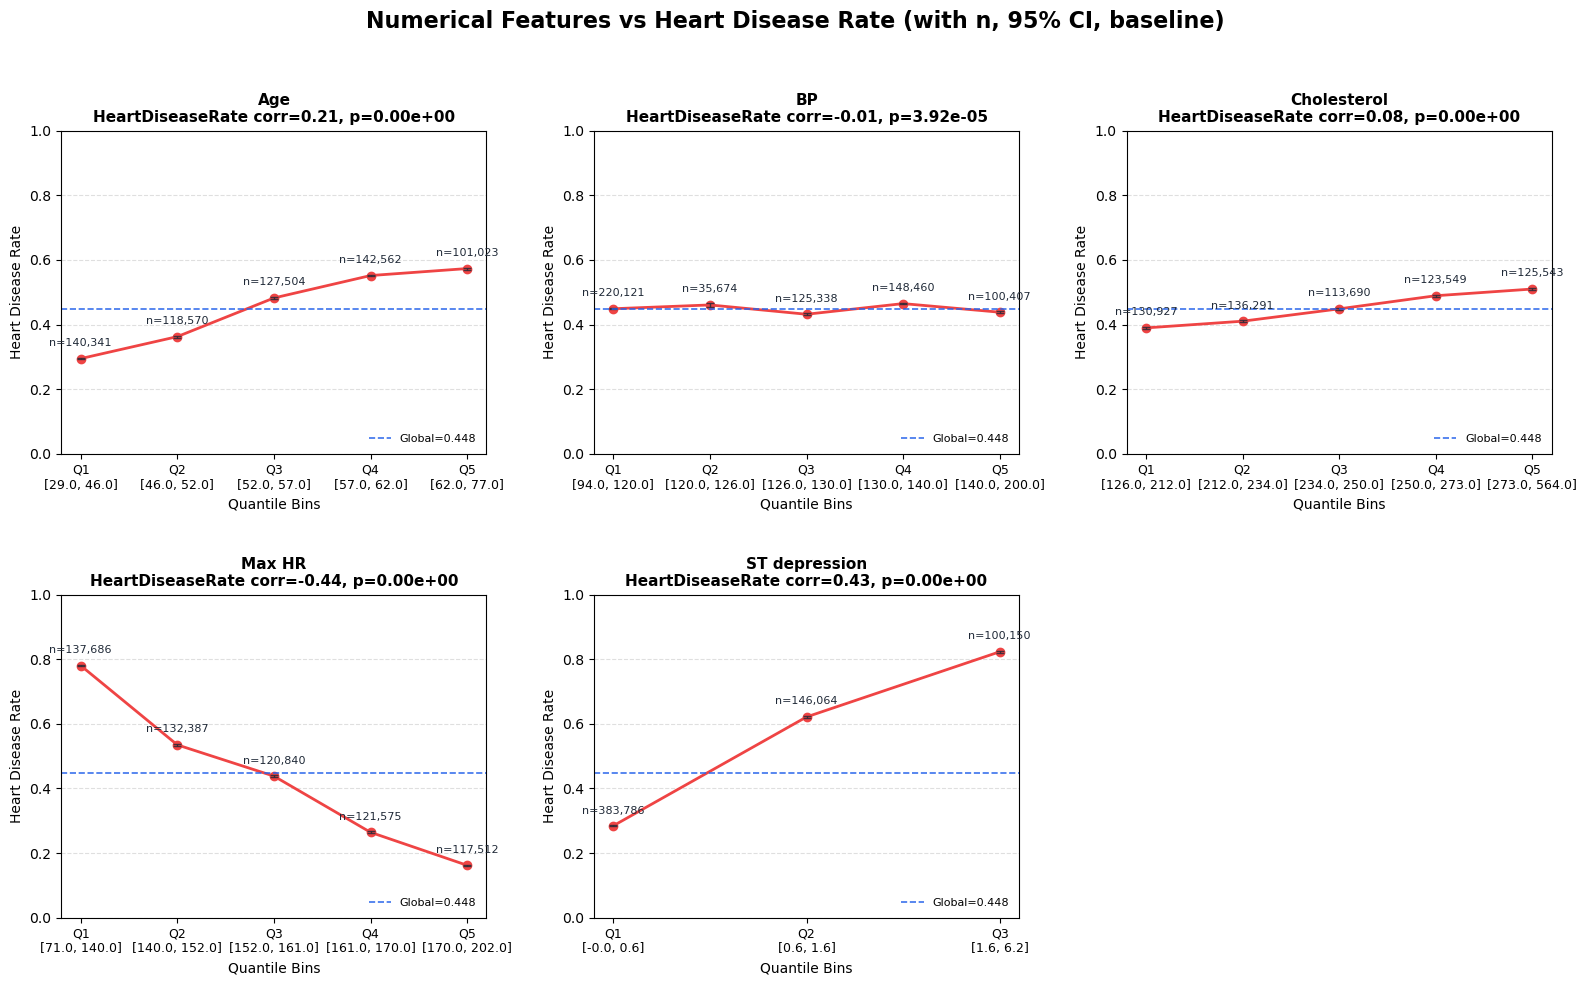


Numeric Single-Feature Ranking (Top 5)


,Item,Value
0,Max HR,"|r|=0.441, p=0.00e+00"
1,ST depression,"|r|=0.431, p=0.00e+00"
2,Age,"|r|=0.212, p=0.00e+00"
3,Cholesterol,"|r|=0.083, p=0.00e+00"
4,BP,"|r|=0.005, p=3.92e-05"


In [15]:
# =================================================================================
# NUMERICAL FEATURES vs TARGET (BINARY CLASSIFICATION)
# =================================================================================
def plot_numerical_vs_binary_target(df, features, target_bin, n_bins=5, cols_per_row=3):
    if len(features) == 0:
        return

    n_rows = (len(features) + cols_per_row - 1) // cols_per_row
    fig, axes = plt.subplots(n_rows, cols_per_row, figsize=figsize_by_rows(n_rows, width=16, row_height=5))
    axes = np.array(axes).reshape(-1)

    for i, col in enumerate(features):
        ax = axes[i]
        try:
            temp = df[[col, target_bin]].dropna().copy()
            temp['bin'] = pd.qcut(temp[col], q=n_bins, duplicates='drop')

            stats_df = temp.groupby('bin', observed=True)[target_bin].agg(['mean', 'count']).reset_index()
            stats_df['se'] = np.sqrt((stats_df['mean'] * (1.0 - stats_df['mean'])) / stats_df['count'].clip(lower=1))
            stats_df['ci95'] = 1.96 * stats_df['se']

            centers = np.arange(len(stats_df))
            y = stats_df['mean'].values
            yerr = stats_df['ci95'].values

            ax.plot(centers, y, marker='o', color=COLORS['low_score'], linewidth=2)
            ax.errorbar(centers, y, yerr=yerr, fmt='none', ecolor=COLORS['dark'], elinewidth=1, capsize=3, alpha=0.8)

            labels = [f"Q{j+1}\n[{interval.left:.1f}, {interval.right:.1f}]" for j, interval in enumerate(stats_df['bin'])]
            ax.set_xticks(centers)
            ax.set_xticklabels(labels, rotation=0, ha='center', fontsize=9)

            baseline = temp[target_bin].mean()
            ax.axhline(baseline, linestyle='--', linewidth=1.2, color=COLORS['primary'], alpha=0.9, label=f'Global={baseline:.3f}')

            for x, yy, ee, nn in zip(centers, y, yerr, stats_df['count'].values):
                y_text = min(0.98, yy + ee + 0.03)
                ax.text(x, y_text, f"n={int(nn):,}", ha='center', va='bottom', fontsize=8, color=COLORS['dark'])

            corr, p = stats.pearsonr(temp[col], temp[target_bin])
            p_text = f"p={p:.2e}" if p < 0.001 else f"p={p:.3f}"
            ax.set_title(f"{col}\nHeartDiseaseRate corr={corr:.2f}, {p_text}", fontweight='bold', fontsize=11)
            ax.set_ylabel('Heart Disease Rate')
            ax.set_xlabel('Quantile Bins')
            ax.set_ylim(0, 1)
            ax.grid(axis='y', linestyle='--', alpha=0.4)
            ax.legend(loc='lower right', fontsize=8, frameon=False)

        except Exception as e:
            ax.text(0.5, 0.5, f"Could not process: {e}", ha='center', va='center', transform=ax.transAxes)

    for j in range(len(features), len(axes)):
        fig.delaxes(axes[j])

    plt.suptitle('Numerical Features vs Heart Disease Rate (with n, 95% CI, baseline)', fontsize=16, fontweight='bold', y=1.0)
    plt.tight_layout(h_pad=3.3, w_pad=2.0, rect=[0, 0.02, 1, 0.97])
    plt.show()

plot_numerical_vs_binary_target(train, NUMS, TARGET_BIN, n_bins=5, cols_per_row=3)


def compute_numeric_signal_ranking(df, features, target_bin):
    rows = []
    for col in [c for c in features if c in df.columns]:
        temp = df[[col, target_bin]].dropna()
        if len(temp) > 1:
            r, p = stats.pearsonr(temp[col], temp[target_bin])
            rows.append({
                'Feature': col,
                'PointBiserial~Pearson (r)': r,
                'Abs_Correlation': abs(r),
                'P_Value': p,
            })

    if not rows:
        return pd.DataFrame()

    rank_df = pd.DataFrame(rows).sort_values('Abs_Correlation', ascending=False).reset_index(drop=True)
    return rank_df


# Keep numeric signal ranking in 3.1 so downstream sections use a single source of truth.
corr_ranking = compute_numeric_signal_ranking(train, NUMS, TARGET_BIN)
if corr_ranking is not None and len(corr_ranking) > 0:
    display_kv(
        'Numeric Single-Feature Ranking (Top 5)',
        [(row['Feature'], f"|r|={row['Abs_Correlation']:.3f}, p={row['P_Value']:.2e}") for _, row in corr_ranking.head(5).iterrows()]
    )
else:
    display_kv('Numeric Single-Feature Ranking', [('Status', 'Unavailable')])


> **Statistical Implication** -- Numeric variables show ordered risk gradients across bins. This supports using monotonic-like splits and interaction terms in tree models.


### 3.2. Categorical Features Impact


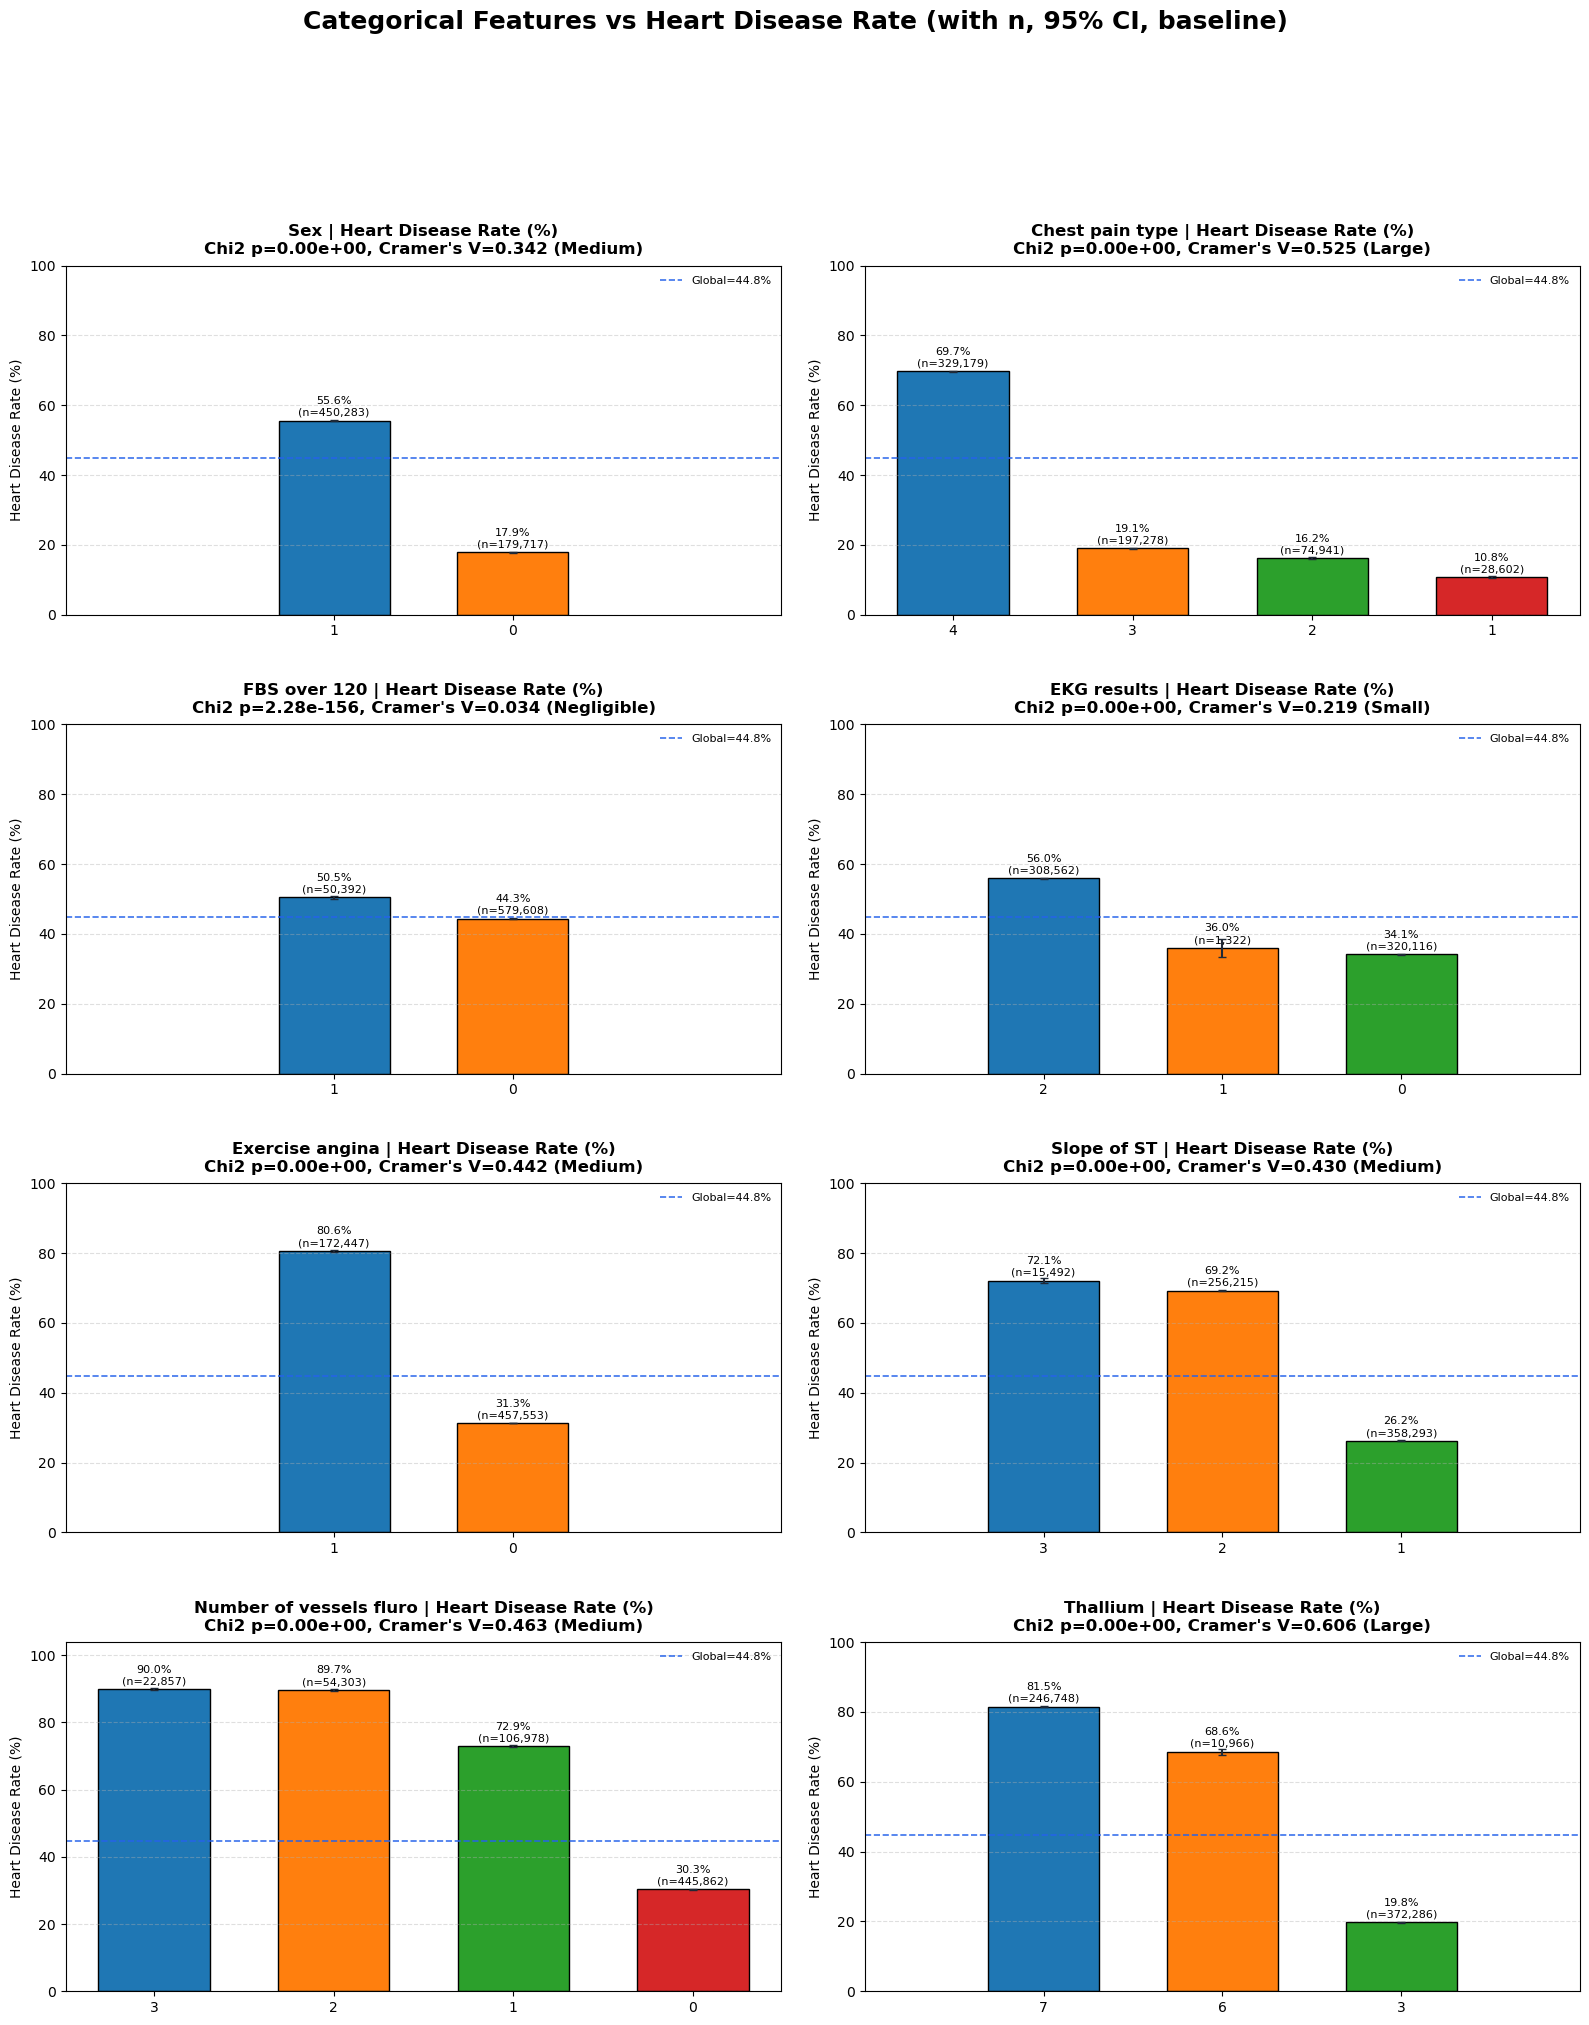

In [16]:
# =================================================================================
# CATEGORICAL FEATURES vs TARGET (BINARY CLASSIFICATION)
# =================================================================================
def plot_categorical_vs_target_binary(df, features, target_col, target_bin_col, cols_per_row=2):
    if len(features) == 0:
        return pd.DataFrame()

    valid_features = [f for f in features if f in df.columns]
    if not valid_features:
        return pd.DataFrame()

    max_levels = max(df[c].nunique() for c in valid_features)
    fixed_bar_width = 0.62

    n_rows = (len(valid_features) + cols_per_row - 1) // cols_per_row
    fig, axes = plt.subplots(n_rows, cols_per_row, figsize=figsize_by_rows(n_rows, width=16, row_height=5))
    axes = np.array(axes).reshape(-1)

    effect_rows = []

    for i, col in enumerate(valid_features):
        ax = axes[i]
        try:
            tmp = df[[col, target_col, target_bin_col]].dropna().copy()

            stats_df = tmp.groupby(col, observed=True)[target_bin_col].agg(['mean', 'count']).reset_index()
            stats_df = stats_df.sort_values('mean', ascending=False).reset_index(drop=True)
            stats_df['rate_pct'] = stats_df['mean'] * 100.0
            stats_df['se'] = np.sqrt((stats_df['mean'] * (1.0 - stats_df['mean'])) / stats_df['count'].clip(lower=1))
            stats_df['ci95_pct'] = 1.96 * stats_df['se'] * 100.0

            x = np.arange(len(stats_df))
            palette = sns.color_palette('tab10', n_colors=len(stats_df))
            bars = ax.bar(
                x,
                stats_df['rate_pct'].values,
                width=fixed_bar_width,
                color=palette,
                edgecolor='black',
                linewidth=1,
                yerr=stats_df['ci95_pct'].values,
                capsize=3,
                ecolor=COLORS['dark']
            )

            contingency = pd.crosstab(tmp[col], tmp[target_col])
            chi2, p, _, _ = stats.chi2_contingency(contingency)
            n = contingency.to_numpy().sum()
            r, k = contingency.shape
            cramers_v = np.sqrt((chi2 / n) / max(min(r - 1, k - 1), 1))

            if cramers_v < 0.1:
                eff = 'Negligible'
            elif cramers_v < 0.3:
                eff = 'Small'
            elif cramers_v < 0.5:
                eff = 'Medium'
            else:
                eff = 'Large'

            effect_rows.append({
                'Feature': col,
                'Cramers_V': cramers_v,
                'P_Value': p,
                'Effect_Label': eff
            })

            baseline_pct = tmp[target_bin_col].mean() * 100.0
            ax.axhline(baseline_pct, linestyle='--', linewidth=1.2, color=COLORS['primary'], alpha=0.9,
                       label=f'Global={baseline_pct:.1f}%')

            p_text = f"p={p:.2e}" if p < 0.001 else f"p={p:.3f}"
            ax.set_title(
                f"{col} | Heart Disease Rate (%)\nChi2 {p_text}, Cramer's V={cramers_v:.3f} ({eff})",
                fontsize=12,
                fontweight='bold',
                pad=8
            )
            ax.set_xlabel('')
            ax.set_ylabel('Heart Disease Rate (%)')
            ymax = max(100, (stats_df['rate_pct'] + stats_df['ci95_pct']).max() * 1.15)
            ax.set_ylim(0, ymax)
            ax.grid(axis='y', linestyle='--', alpha=0.4)

            ax.set_xticks(x)
            ax.set_xticklabels(stats_df[col].astype(str).tolist())

            if len(stats_df) < max_levels:
                pad = (max_levels - len(stats_df)) / 2.0
                ax.set_xlim(-0.5 - pad, len(stats_df) - 0.5 + pad)

            for b, nn in zip(bars, stats_df['count'].values):
                h = b.get_height()
                ax.annotate(
                    f"{h:.1f}%\n(n={int(nn):,})",
                    (b.get_x() + b.get_width() / 2, h),
                    ha='center', va='bottom', fontsize=8, xytext=(0, 2), textcoords='offset points'
                )

            if len(stats_df[col].astype(str).tolist()) > 4:
                ax.tick_params(axis='x', rotation=25)

            ax.legend(loc='upper right', fontsize=8, frameon=False)

        except Exception as e:
            ax.text(0.5, 0.5, f"Error: {str(e)}", ha='center', va='center', transform=ax.transAxes)

    for j in range(len(valid_features), len(axes)):
        fig.delaxes(axes[j])

    plt.suptitle('Categorical Features vs Heart Disease Rate (with n, 95% CI, baseline)', fontsize=18, fontweight='bold', y=1.03)
    plt.tight_layout(h_pad=3.2, w_pad=2.0, rect=[0, 0.02, 1, 0.95])
    plt.show()

    effect_df = pd.DataFrame(effect_rows).sort_values('Cramers_V', ascending=False)
    return effect_df

if 'CATS' in globals() and CATS:
    cat_effect_df = plot_categorical_vs_target_binary(train, CATS, TARGET, TARGET_BIN, cols_per_row=2)


> **Statistical Implication** -- Effect sizes differ widely across categorical features. Prioritize high-effect categorical variables first for model complexity budget.


## 4. Multivariate Analysis


### 4.1. Feature-Only Correlation Structure



Multivariate Analysis


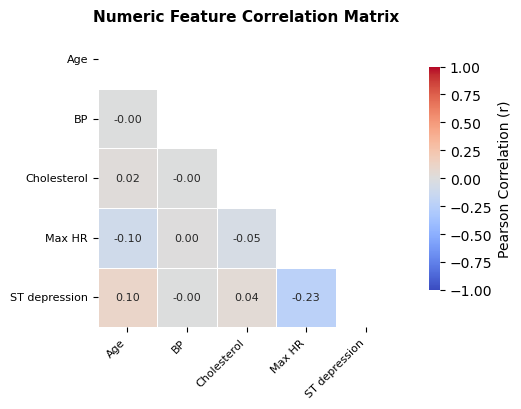


High-Correlation Pairs (|r| > 0.7)

High-Correlation Pairs


,Item,Value
0,Status,No high-correlation pairs detected among numeric features


In [17]:
# =================================================================================
# MULTIVARIATE ANALYSIS: CORRELATION + COLLINEARITY
# =================================================================================
def analyze_multivariate_structure(df, features):
    print_section('Multivariate Analysis', width=40)

    corr_data = df[features].select_dtypes(include=[np.number]).copy()
    corr_matrix = corr_data.corr()

    plt.figure(figsize=(7.0, 4.2))
    mask = np.triu(np.ones_like(corr_matrix, dtype=bool))
    sns.heatmap(
        corr_matrix,
        mask=mask,
        annot=True,
        fmt='.2f',
        cmap='coolwarm',
        vmin=-1,
        vmax=1,
        center=0,
        square=True,
        linewidths=0.5,
        linecolor='white',
        cbar_kws={'shrink': 0.75, 'label': 'Pearson Correlation (r)'},
        annot_kws={'size': 8}
    )
    plt.title('Numeric Feature Correlation Matrix', fontsize=11, fontweight='bold')
    plt.xticks(rotation=45, ha='right', fontsize=8)
    plt.yticks(rotation=0, fontsize=8)
    plt.tight_layout()
    plt.show()

    print_section('High-Correlation Pairs (|r| > 0.7)')

    high_corr_list = []
    cols = corr_matrix.columns
    for i in range(len(cols)):
        for j in range(i + 1, len(cols)):
            r_val = corr_matrix.iloc[i, j]
            if abs(r_val) > 0.7:
                high_corr_list.append({
                    'Feature A': cols[i],
                    'Feature B': cols[j],
                    'Correlation (r)': r_val,
                    'Interpretation': 'Very High' if abs(r_val) > 0.9 else 'High'
                })

    if high_corr_list:
        high_corr_df = pd.DataFrame(high_corr_list).sort_values('Correlation (r)', key=abs, ascending=False)
        display(high_corr_df.style.background_gradient(subset=['Correlation (r)'], cmap='coolwarm', vmin=-1, vmax=1)
                                .format({'Correlation (r)': '{:.3f}'}))
    else:
        display_kv('High-Correlation Pairs', [('Status', 'No high-correlation pairs detected among numeric features')])

if 'NUMS' in globals() and NUMS:
    analyze_multivariate_structure(train, NUMS)


> **Statistical Implication** -- Feature-feature dependence is present but not extreme in pairwise correlations. Collinearity risk appears manageable for tree ensembles and regularized models.


### 4.2. VIF-Based Redundancy Check


In [18]:
# =================================================================================
# VIF CHECK (LINEAR REDUNDANCY DIAGNOSTIC)
# =================================================================================
def calculate_vif_manual(df, features):
    x_df = df[features].select_dtypes(include=[np.number]).dropna().copy()
    cols = x_df.columns.tolist()

    if len(cols) < 2:
        display_kv('VIF Summary', [('Status', 'Skipped'), ('Reason', 'Need at least 2 numeric features')])
        return pd.DataFrame()

    X = x_df.values.astype(float)
    rows = []

    for i, col in enumerate(cols):
        y = X[:, i]
        X_others = np.delete(X, i, axis=1)
        X_design = np.column_stack([np.ones(len(X_others)), X_others])

        # OLS fit via least squares
        beta, *_ = np.linalg.lstsq(X_design, y, rcond=None)
        y_hat = X_design @ beta

        ss_res = np.sum((y - y_hat) ** 2)
        ss_tot = np.sum((y - y.mean()) ** 2)
        r2 = 0.0 if ss_tot == 0 else 1 - (ss_res / ss_tot)
        r2 = min(max(r2, 0.0), 0.999999)

        vif = 1.0 / (1.0 - r2)
        tol = 1.0 / vif

        if vif < 5:
            risk = 'Low'
        elif vif < 10:
            risk = 'Moderate'
        else:
            risk = 'High'

        rows.append({'Feature': col, 'R2_with_others': r2, 'VIF': vif, 'Tolerance': tol, 'Risk': risk})

    vif_df = pd.DataFrame(rows).sort_values('VIF', ascending=False)

    print_section('VIF Summary')
    display_notes('VIF Rule of Thumb', 'VIF < 5: good, 5~10: watch, >10: high collinearity risk')

    display(vif_df.style.format({'R2_with_others': '{:.4f}', 'VIF': '{:.3f}', 'Tolerance': '{:.4f}'})
                  .background_gradient(subset=['VIF'], cmap='Reds'))

    return vif_df

if 'NUMS' in globals() and NUMS:
    vif_df = calculate_vif_manual(train, NUMS)



VIF Summary

VIF Rule of Thumb


,Item,Value
0,Notes,"VIF < 5: good, 5~10: watch, >10: high collinearity risk"


,Feature,R2_with_others,VIF,Tolerance,Risk
4,ST depression,0.0603,1.064,0.9397,Low
3,Max HR,0.0596,1.063,0.9404,Low
0,Age,0.0165,1.017,0.9835,Low
2,Cholesterol,0.0037,1.004,0.9963,Low
1,BP,0.0001,1.000,0.9999,Low


> **Statistical Implication** -- VIF highlights linear redundancy that pairwise correlation may miss. High-VIF variables should be reviewed for pruning or interaction-only usage.


### 4.3. NUM Pairwise Interaction Heatmaps


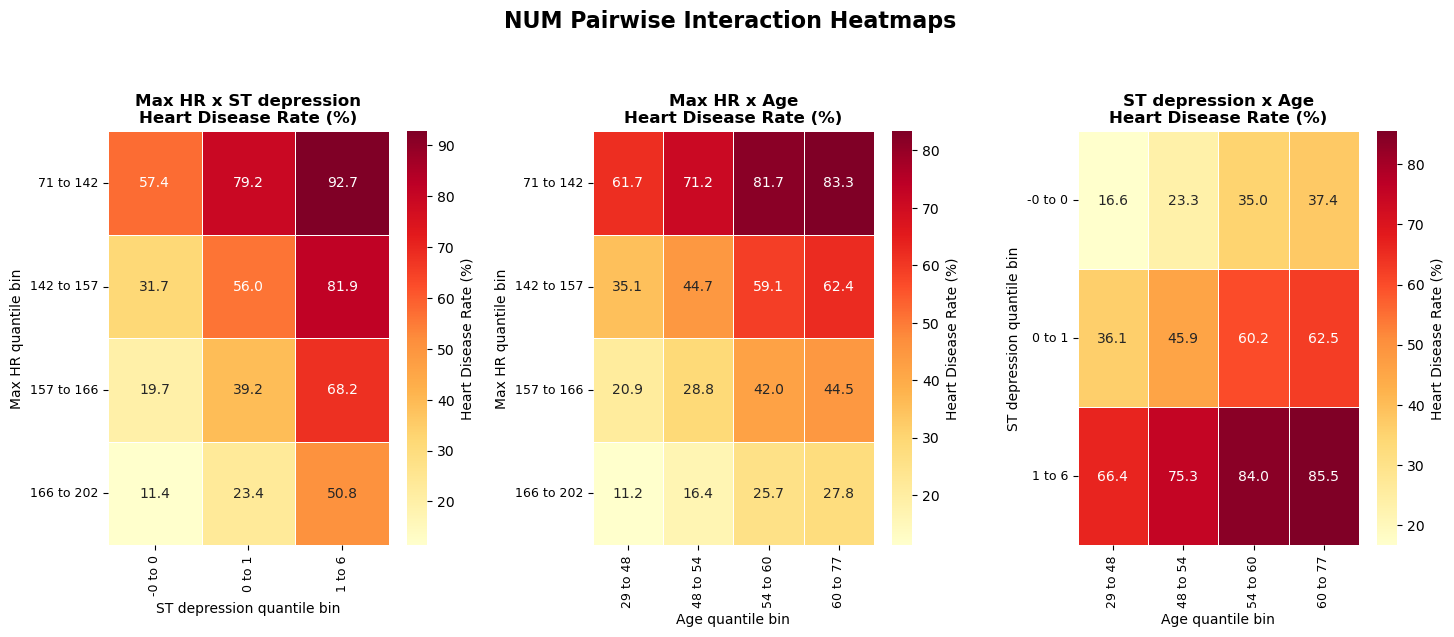


Num Interaction Intuition (From Pairwise Heatmaps)


,Pair,Max_Cell,Max_Rate(%),Min_Cell,Min_Rate(%),Range(%)
0,Max HR x ST depression,71 to 142 | 1 to 6,92.74,166 to 202 | -0 to 0,11.40,81.34
1,Max HR x Age,71 to 142 | 60 to 77,83.32,166 to 202 | 29 to 48,11.24,72.08
2,ST depression x Age,1 to 6 | 60 to 77,85.50,-0 to 0 | 29 to 48,16.60,68.90



Numeric Interaction Intuition


,Item,Value
0,Notes,Strongest non-additive contrast: Max HR x ST depression (range ≈ 81.34pp). Combined bins create sharper risk separation than single-variable views.


In [19]:
# =================================================================================
# NUM PAIRWISE INTERACTION HEATMAPS (Heart Disease Rate)
# =================================================================================
def plot_num_pairwise_interactions(df, num_cols, target_bin_col='target_bin', top_k=3, q=4):
    # Shorten interval labels to prevent axis text overlap.
    def _short_interval_label(v):
        if hasattr(v, 'left') and hasattr(v, 'right'):
            return f"{v.left:.0f} to {v.right:.0f}"
        txt = str(v).replace('[', '').replace(']', '').replace('(', '').replace(')', '')
        parts = [p.strip() for p in txt.split(',')]
        if len(parts) == 2:
            try:
                return f"{float(parts[0]):.0f} to {float(parts[1]):.0f}"
            except Exception:
                return txt
        return txt
    if target_bin_col not in df.columns:
        display_kv('Pairwise Interaction Check', [('Status', 'Skipped'), ('Reason', f'Missing target bin column: {target_bin_col}')])
        return pd.DataFrame()

    valid_nums = [c for c in num_cols if c in df.columns]
    if len(valid_nums) < 2:
        display_kv('Pairwise Interaction Check', [('Status', 'Skipped'), ('Reason', 'Need at least 2 numeric features')])
        return pd.DataFrame()

    chosen = valid_nums
    if 'corr_ranking' in globals() and isinstance(corr_ranking, pd.DataFrame) and not corr_ranking.empty:
        if 'Feature' in corr_ranking.columns:
            ranked = [f for f in corr_ranking['Feature'].tolist() if f in valid_nums]
            if ranked:
                chosen = ranked

    chosen = chosen[:max(top_k, 2)]

    pairs = []
    for i in range(len(chosen)):
        for j in range(i + 1, len(chosen)):
            pairs.append((chosen[i], chosen[j]))

    if not pairs:
        display_kv('Pairwise Interaction Check', [('Status', 'No numeric pairs available')])
        return pd.DataFrame()

    n = len(pairs)
    fig, axes = plt.subplots(1, n, figsize=(max(FIG_WIDTH, 4.9 * n), 6.2))
    if n == 1:
        axes = [axes]

    summary_rows = []

    for ax, (a, b) in zip(axes, pairs):
        tmp = df[[a, b, target_bin_col]].dropna().copy()
        tmp[f'{a}_bin'] = pd.qcut(tmp[a], q=q, duplicates='drop')
        tmp[f'{b}_bin'] = pd.qcut(tmp[b], q=q, duplicates='drop')

        pivot = tmp.pivot_table(
            index=f'{a}_bin', columns=f'{b}_bin', values=target_bin_col,
            aggfunc='mean', observed=True
        ) * 100

        pivot.index = [_short_interval_label(v) for v in pivot.index]
        pivot.columns = [_short_interval_label(v) for v in pivot.columns]

        sns.heatmap(
            pivot,
            annot=True,
            fmt='.1f',
            cmap='YlOrRd',
            linewidths=0.5,
            linecolor='white',
            cbar_kws={'label': 'Heart Disease Rate (%)'},
            ax=ax
        )
        ax.set_title(f'{a} x {b}\nHeart Disease Rate (%)', fontsize=12, fontweight='bold')
        ax.set_xlabel(f'{b} quantile bin')
        ax.set_ylabel(f'{a} quantile bin')
        ax.set_yticklabels(ax.get_yticklabels(), rotation=0, fontsize=9)
        ax.set_xticklabels(ax.get_xticklabels(), rotation=90, fontsize=9)

        max_idx = np.unravel_index(np.nanargmax(pivot.values), pivot.shape)
        min_idx = np.unravel_index(np.nanargmin(pivot.values), pivot.shape)
        max_rate = float(pivot.values[max_idx])
        min_rate = float(pivot.values[min_idx])

        summary_rows.append({
            'Pair': f'{a} x {b}',
            'Max_Cell': f"{pivot.index[max_idx[0]]} | {pivot.columns[max_idx[1]]}",
            'Max_Rate(%)': max_rate,
            'Min_Cell': f"{pivot.index[min_idx[0]]} | {pivot.columns[min_idx[1]]}",
            'Min_Rate(%)': min_rate,
            'Range(%)': max_rate - min_rate
        })

    plt.suptitle('NUM Pairwise Interaction Heatmaps', fontsize=16, fontweight='bold', y=1.02)
    plt.tight_layout(rect=[0, 0, 1, 0.97])
    plt.show()

    num_pair_df = pd.DataFrame(summary_rows).sort_values('Range(%)', ascending=False)

    print_section('Num Interaction Intuition (From Pairwise Heatmaps)')
    display(num_pair_df.style.format({'Max_Rate(%)': '{:.2f}', 'Min_Rate(%)': '{:.2f}', 'Range(%)': '{:.2f}'})
                          .background_gradient(subset=['Range(%)'], cmap='OrRd'))

    if not num_pair_df.empty:
        top = num_pair_df.iloc[0]
        display_notes('Numeric Interaction Intuition', [f"Strongest non-additive contrast: {top['Pair']} (range ≈ {top['Range(%)']:.2f}pp).", 'Combined bins create sharper risk separation than single-variable views.'])

    return num_pair_df

num_pair_df = plot_num_pairwise_interactions(train, NUMS, target_bin_col=TARGET_BIN, top_k=3, q=4)


> **Statistical Implication** -- Joint numeric bins reveal risk contrasts stronger than marginal views. These patterns justify candidate interaction features for model tests.


### 4.4. CAT Pairwise Interaction Heatmaps


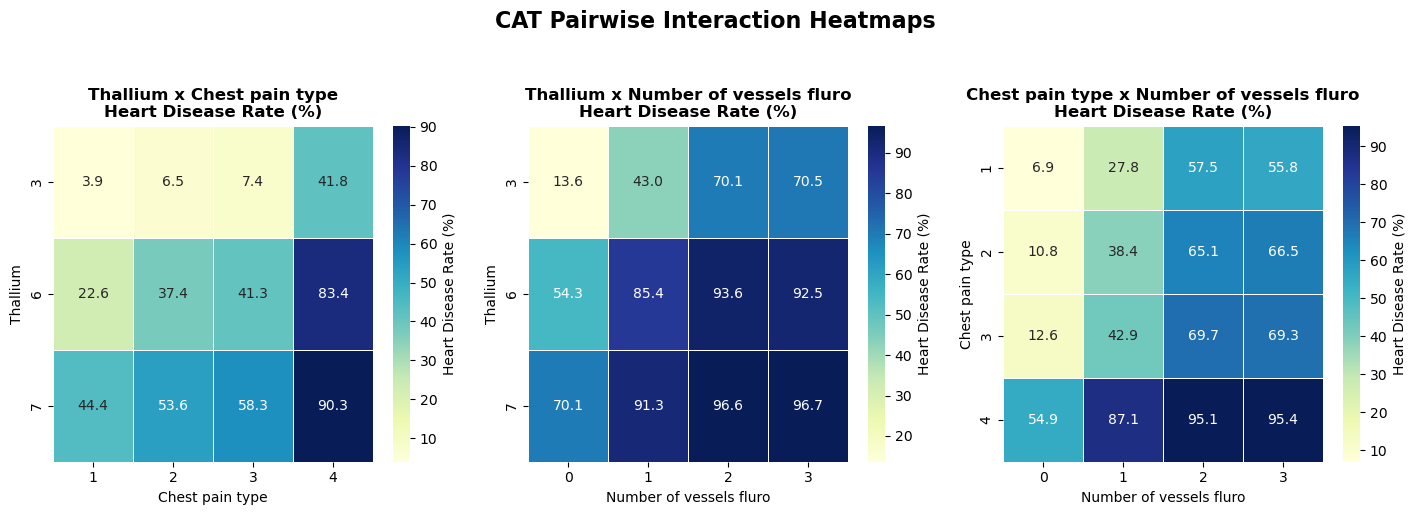


Cat Interaction Intuition (From Pairwise Heatmaps)


,Pair,High_Risk_Combo,High_Rate(%),High_Count,Low_Risk_Combo,Low_Rate(%),Low_Count,Gap(%)
2,Chest pain type x Number of vessels fluro,"Chest pain type=4.0, Number of vessels fluro=3.0",95.40,18345,"Chest pain type=1.0, Number of vessels fluro=0.0",6.93,24770,88.47
0,Thallium x Chest pain type,"Thallium=7.0, Chest pain type=4.0",90.32,183366,"Thallium=3.0, Chest pain type=1.0",3.94,23596,86.38
1,Thallium x Number of vessels fluro,"Thallium=7.0, Number of vessels fluro=3.0",96.73,16455,"Thallium=3.0, Number of vessels fluro=0.0",13.63,312260,83.10



Categorical Interaction Intuition


,Item,Value
0,Notes,Strongest categorical interaction contrast: Chest pain type x Number of vessels fluro (gap ≈ 88.47pp). Category combinations capture risk tiers beyond single-category averages.


In [20]:
# =================================================================================
# CAT PAIRWISE INTERACTION HEATMAPS (Heart Disease Rate)
# =================================================================================
def plot_cat_pairwise_interactions(df, cat_cols, target_bin_col='target_bin', top_k=3, min_count=200):
    if target_bin_col not in df.columns:
        display_kv('Pairwise Interaction Check', [('Status', 'Skipped'), ('Reason', f'Missing target bin column: {target_bin_col}')])
        return pd.DataFrame()

    valid_cats = [c for c in cat_cols if c in df.columns]
    if len(valid_cats) < 2:
        display_kv('Pairwise Interaction Check', [('Status', 'Skipped'), ('Reason', 'Need at least 2 categorical features')])
        return pd.DataFrame()

    chosen = valid_cats
    if 'cat_effect_df' in globals() and isinstance(cat_effect_df, pd.DataFrame) and not cat_effect_df.empty:
        if 'Feature' in cat_effect_df.columns:
            ranked = [f for f in cat_effect_df['Feature'].tolist() if f in valid_cats]
            if ranked:
                chosen = ranked

    chosen = chosen[:max(top_k, 2)]

    pairs = []
    for i in range(len(chosen)):
        for j in range(i + 1, len(chosen)):
            pairs.append((chosen[i], chosen[j]))

    if not pairs:
        display_kv('Pairwise Interaction Check', [('Status', 'No categorical pairs available')])
        return pd.DataFrame()

    n = len(pairs)
    fig, axes = plt.subplots(1, n, figsize=(max(FIG_WIDTH, 4.8 * n), 5))
    if n == 1:
        axes = [axes]

    summary_rows = []

    for ax, (a, b) in zip(axes, pairs):
        tmp = df[[a, b, target_bin_col]].dropna().copy()
        pivot = tmp.pivot_table(index=a, columns=b, values=target_bin_col, aggfunc='mean', observed=True) * 100

        sns.heatmap(
            pivot,
            annot=True,
            fmt='.1f',
            cmap='YlGnBu',
            linewidths=0.5,
            linecolor='white',
            cbar_kws={'label': 'Heart Disease Rate (%)'},
            ax=ax
        )
        ax.set_title(f'{a} x {b}\nHeart Disease Rate (%)', fontsize=12, fontweight='bold')
        ax.set_xlabel(b)
        ax.set_ylabel(a)

        combo = tmp.groupby([a, b], observed=True)[target_bin_col].agg(['mean', 'size']).reset_index()
        combo['Rate(%)'] = combo['mean'] * 100
        combo = combo.rename(columns={'size': 'Count'})

        stable = combo[combo['Count'] >= min_count].copy()
        if stable.empty:
            stable = combo.copy()

        hi = stable.sort_values('Rate(%)', ascending=False).iloc[0]
        lo = stable.sort_values('Rate(%)', ascending=True).iloc[0]

        summary_rows.append({
            'Pair': f'{a} x {b}',
            'High_Risk_Combo': f"{a}={hi[a]}, {b}={hi[b]}",
            'High_Rate(%)': float(hi['Rate(%)']),
            'High_Count': int(hi['Count']),
            'Low_Risk_Combo': f"{a}={lo[a]}, {b}={lo[b]}",
            'Low_Rate(%)': float(lo['Rate(%)']),
            'Low_Count': int(lo['Count']),
            'Gap(%)': float(hi['Rate(%)'] - lo['Rate(%)'])
        })

    plt.suptitle('CAT Pairwise Interaction Heatmaps', fontsize=16, fontweight='bold', y=1.02)
    plt.tight_layout(rect=[0, 0, 1, 0.97])
    plt.show()

    cat_pair_df = pd.DataFrame(summary_rows).sort_values('Gap(%)', ascending=False)

    print_section('Cat Interaction Intuition (From Pairwise Heatmaps)')
    display(cat_pair_df.style.format({'High_Rate(%)': '{:.2f}', 'Low_Rate(%)': '{:.2f}', 'Gap(%)': '{:.2f}'})
                          .background_gradient(subset=['Gap(%)'], cmap='YlGnBu'))

    if not cat_pair_df.empty:
        top = cat_pair_df.iloc[0]
        display_notes('Categorical Interaction Intuition', [f"Strongest categorical interaction contrast: {top['Pair']} (gap ≈ {top['Gap(%)']:.2f}pp).", 'Category combinations capture risk tiers beyond single-category averages.'])

    return cat_pair_df

cat_pair_df = plot_cat_pairwise_interactions(train, CATS, target_bin_col=TARGET_BIN, top_k=3, min_count=200)


> **Statistical Implication** -- Category combinations create distinct risk tiers beyond single-category averages. Pairwise CAT interactions are valid candidates for higher-order feature engineering.


## 5. Final Modeling Playbook
This section consolidates key statistical insights from earlier sections and maps them directly to modeling actions.


In [23]:
# =================================================================================
# FINAL INSIGHT + RECOMMENDATION
# =================================================================================
def final_playbook_from_eda(num_signal_df=None, cat_signal_df=None, ks_df=None, smd_df=None, vif_df=None,
                            num_pair_df=None, cat_pair_df=None):
    print_section('Final EDA Insights and Modeling Recommendation')

    def print_note(lines):
        print('Note:')
        for line in lines:
            print(f'- {line}')

    display_kv('Data Quality Status', [
        ('Missing Values', 'None detected'),
        ('Duplicate Feature Rows', 'None detected'),
    ])
    print_note([
        'No missing values means imputation is not required, reducing preprocessing complexity.',
        'No duplicate feature rows lowers leakage/noise risk from repeated observations.',
        'Practical implication: baseline models can focus on signal learning instead of data cleaning fixes.'
    ])

    drift_rows = []
    if ks_df is not None and len(ks_df) > 0 and 'KS_Statistic' in ks_df.columns:
        drift_rows.append(('KS Max Statistic', f"{ks_df['KS_Statistic'].max():.4f}"))
    else:
        drift_rows.append(('KS Summary', 'Unavailable'))

    if smd_df is not None and len(smd_df) > 0 and 'SMD (Sigma)' in smd_df.columns:
        max_smd = smd_df['SMD (Sigma)'].max()
        n_shift = int((smd_df['SMD (Sigma)'] > 0.1).sum())
        drift_rows.append(('SMD Max', f'{max_smd:.4f}'))
        drift_rows.append(('Shifted Features (>0.1)', n_shift))
    else:
        drift_rows.append(('SMD Summary', 'Unavailable'))
    display_kv('Drift Status', drift_rows)

    ks_val = None
    if ks_df is not None and len(ks_df) > 0 and 'KS_Statistic' in ks_df.columns:
        ks_val = float(ks_df['KS_Statistic'].max())

    if ks_val is None:
        drift_msg = 'KS summary is unavailable, so train-test distribution stability should be re-checked.'
    elif ks_val < 0.05:
        drift_msg = f'KS max={ks_val:.4f} indicates low train-test drift (generally stable feature distribution).'
    elif ks_val < 0.10:
        drift_msg = f'KS max={ks_val:.4f} indicates mild drift; monitor validation/LB gap closely.'
    else:
        drift_msg = f'KS max={ks_val:.4f} indicates notable drift; consider robust CV and drift-aware feature handling.'

    smd_msg = 'SMD summary unavailable, so mean-shift evidence is incomplete.'
    if smd_df is not None and len(smd_df) > 0 and 'SMD (Sigma)' in smd_df.columns:
        smd_msg = f'SMD max={max_smd:.4f}, shifted features={n_shift}; values <=0.1 are typically considered small.'

    print_note([
        drift_msg,
        smd_msg,
        'Practical implication: lower drift means CV score is more likely to transfer to public/private leaderboard.'
    ])

    signal_rows = []
    if num_signal_df is not None and len(num_signal_df) > 0 and 'PointBiserial~Pearson (r)' in num_signal_df.columns:
        num_top = num_signal_df.assign(abs_score=num_signal_df['PointBiserial~Pearson (r)'].abs()).sort_values('abs_score', ascending=False).head(3)
        for _, row in num_top.iterrows():
            signal_rows.append((f"NUM: {row['Feature']}", f"|r|={row['abs_score']:.3f}"))

    if cat_signal_df is not None and len(cat_signal_df) > 0 and 'Cramers_V' in cat_signal_df.columns:
        cat_top = cat_signal_df.sort_values('Cramers_V', ascending=False).head(5)
        for _, row in cat_top.iterrows():
            signal_rows.append((f"CAT: {row['Feature']}", f"Cramer's V={row['Cramers_V']:.3f}, {row['Effect_Label']}"))

    if signal_rows:
        display_kv('Strong Single-Feature Signals', signal_rows)
    else:
        display_kv('Strong Single-Feature Signals', [('Status', 'Unavailable')])

    interaction_rows = []
    if num_pair_df is not None and len(num_pair_df) > 0 and 'Range(%)' in num_pair_df.columns:
        top_num_pair = num_pair_df.iloc[0]
        interaction_rows.append(('NUM Interaction Highlight', f"{top_num_pair['Pair']} (range ≈ {top_num_pair['Range(%)']:.2f}pp)"))
    else:
        interaction_rows.append(('NUM Interaction Summary', 'Unavailable'))

    if cat_pair_df is not None and len(cat_pair_df) > 0 and 'Gap(%)' in cat_pair_df.columns:
        top_cat_pair = cat_pair_df.iloc[0]
        interaction_rows.append(('CAT Interaction Highlight', f"{top_cat_pair['Pair']} (gap ≈ {top_cat_pair['Gap(%)']:.2f}pp)"))
    else:
        interaction_rows.append(('CAT Interaction Summary', 'Unavailable'))
    display_kv('Pairwise Interaction Intuition', interaction_rows)

    display_kv('Final Recommendation', [
        ('Validation', 'StratifiedKFold (5 folds) with fixed seeds'),
        ('Main Metric', 'ROC-AUC (plus PR-AUC/F1 as secondary)'),
        ('Model Priority', 'CatBoostClassifier -> LightGBM/XGBoost challengers'),
        ('Feature Policy', 'Keep categorical code features categorical; add pairwise interactions with stable CV gain'),
        ('Threshold & Calibration', 'Tune decision threshold and validate calibration by subgroup'),
        ('Monitoring', 'Recompute KS/SMD periodically for drift alerts'),
    ], wrap_width=120)

# Run final playbook
final_playbook_from_eda(
    num_signal_df=corr_ranking if 'corr_ranking' in globals() else None,
    cat_signal_df=cat_effect_df if 'cat_effect_df' in globals() else None,
    ks_df=ks_drift_df if 'ks_drift_df' in globals() else None,
    smd_df=smd_drift_df if 'smd_drift_df' in globals() else None,
    vif_df=vif_df if 'vif_df' in globals() else None,
    num_pair_df=num_pair_df if 'num_pair_df' in globals() else None,
    cat_pair_df=cat_pair_df if 'cat_pair_df' in globals() else None
)



Final EDA Insights and Modeling Recommendation

Data Quality Status


,Item,Value
0,Missing Values,None detected
1,Duplicate Feature Rows,None detected


Note:
- No missing values means imputation is not required, reducing preprocessing complexity.
- No duplicate feature rows lowers leakage/noise risk from repeated observations.
- Practical implication: baseline models can focus on signal learning instead of data cleaning fixes.

Drift Status


,Item,Value
0,KS Max Statistic,0.0026
1,SMD Summary,Unavailable


Note:
- KS max=0.0026 indicates low train-test drift (generally stable feature distribution).
- SMD summary unavailable, so mean-shift evidence is incomplete.
- Practical implication: lower drift means CV score is more likely to transfer to public/private leaderboard.

Strong Single-Feature Signals


,Item,Value
0,NUM: Max HR,|r|=0.441
1,NUM: ST depression,|r|=0.431
2,NUM: Age,|r|=0.212
3,CAT: Thallium,"Cramer's V=0.606, Large"
4,CAT: Chest pain type,"Cramer's V=0.525, Large"
5,CAT: Number of vessels fluro,"Cramer's V=0.463, Medium"
6,CAT: Exercise angina,"Cramer's V=0.442, Medium"
7,CAT: Slope of ST,"Cramer's V=0.430, Medium"



Pairwise Interaction Intuition


,Item,Value
0,NUM Interaction Highlight,Max HR x ST depression (range ≈ 81.34pp)
1,CAT Interaction Highlight,Chest pain type x Number of vessels fluro (gap ≈ 88.47pp)



Final Recommendation


,Item,Value
0,Validation,StratifiedKFold (5 folds) with fixed seeds
1,Main Metric,ROC-AUC (plus PR-AUC/F1 as secondary)
2,Model Priority,CatBoostClassifier -> LightGBM/XGBoost challengers
3,Feature Policy,Keep categorical code features categorical; add pairwise interactions with stable CV gain
4,Threshold & Calibration,Tune decision threshold and validate calibration by subgroup
5,Monitoring,Recompute KS/SMD periodically for drift alerts
